# Diffusion models - DDPM

## 0. Denoising Diffusion Probabilistic Models

Paper: https://arxiv.org/abs/2006.11239

Code: https://github.com/explainingai-code/DDPM-Pytorch

<img src="static/paper_ddpm_figure_1.png" width="500">

### 0.1 Diffusion: from physics to probability

In [1]:
# Imports
import math
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Load data
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

 <img src="static/physics_diffusion.png" width="500">

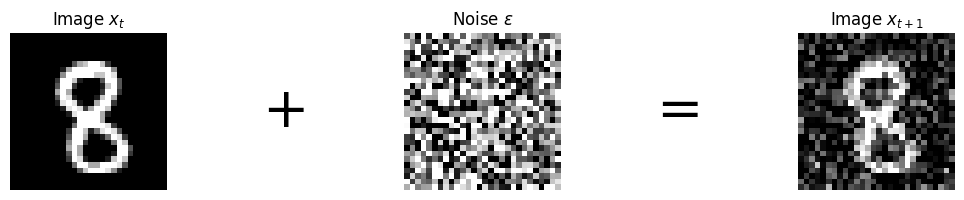

In [3]:
# Illustrate how Image + Noise = Diffused Image

sample_idx = np.random.randint(len(train_dataset))
sample_image, sample_label = train_dataset[sample_idx]  # normalized ~[-1, 1]
eps = torch.randn_like(sample_image)

beta = 0.25
signal_part = torch.sqrt(torch.tensor(1 - beta, dtype=sample_image.dtype, device=sample_image.device)) * sample_image
noise_part  = torch.sqrt(torch.tensor(beta, dtype=sample_image.dtype, device=sample_image.device)) * eps
diffused = signal_part + noise_part

vmin, vmax = -1, 1  # fixed range for normalized images

fig, axes = plt.subplots(1, 5, figsize=(10, 2))

axes[0].imshow(sample_image.squeeze().cpu(), cmap="gray", vmin=vmin, vmax=vmax)
axes[0].set_title("Image $x_t$")
axes[0].axis("off")

axes[1].text(0.5, 0.5, "+", fontsize=40, ha="center", va="center")
axes[1].axis("off")

axes[2].imshow(eps.clamp(vmin, vmax).squeeze().cpu(), cmap="gray", vmin=vmin, vmax=vmax)
axes[2].set_title(r"Noise $\varepsilon$")
axes[2].axis("off")

axes[3].text(0.5, 0.5, "=", fontsize=40, ha="center", va="center")
axes[3].axis("off")

axes[4].imshow(diffused.squeeze().cpu(), cmap="gray", vmin=vmin, vmax=vmax)
axes[4].set_title("Image $x_{t+1}$")
axes[4].axis("off")

plt.tight_layout()
plt.show()

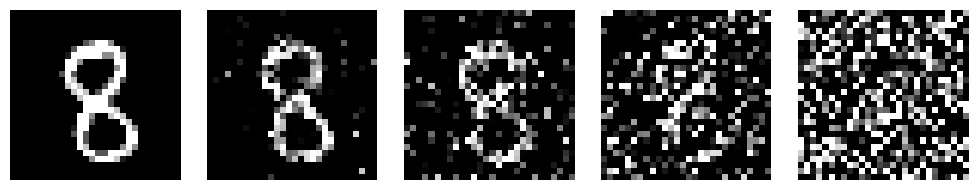

In [4]:
# Diffuse image step by step

import matplotlib.pyplot as plt
import numpy as np

# Define different beta values to test (5 levels)
beta_values = np.array([0.0, 0.25, 0.5, 0.75, 1.0])

# Create a figure to show the effect of different betas
fig, axes = plt.subplots(1, 5, figsize=(10, 2))

# Convert sample_image to numpy array to avoid __array__ deprecation warning
sample_image_np = np.asarray(sample_image)

for idx, beta in enumerate(beta_values):
    # Apply forward diffusion with the given beta
    noise = np.random.randn(*sample_image_np.shape)
    noisy_image = np.sqrt(1 - beta) * sample_image_np + np.sqrt(beta) * noise
    
    # Clip values to valid range
    noisy_image = np.clip(noisy_image, 0, 1)
    
    # Display the noisy image
    axes[idx].imshow(noisy_image.squeeze(), cmap='gray')
    # axes[idx].set_title(f'β = {beta:.2f}')
    axes[idx].axis('off')

# plt.suptitle('Effect of Different Beta Values on Forward Diffusion', fontsize=14)
plt.tight_layout()
plt.show()


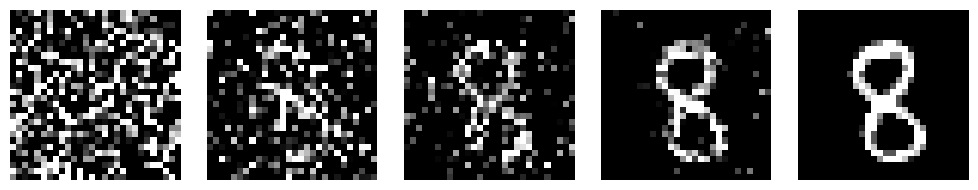

In [5]:
# Revert the diffusion process step by step

import matplotlib.pyplot as plt
import numpy as np

# Define different beta values to test (5 levels) - in reverse order
beta_values = np.array([1.0, 0.75, 0.5, 0.25, 0.0])

# Create a figure to show the effect of different betas
fig, axes = plt.subplots(1, 5, figsize=(10, 2))

# Convert sample_image to numpy array to avoid __array_wrap__ deprecation warning
sample_image_np = np.asarray(sample_image)

for idx, beta in enumerate(beta_values):
    # Apply forward diffusion with the given beta
    noise = np.random.randn(*sample_image_np.shape)
    noisy_image = np.sqrt(1 - beta) * sample_image_np + np.sqrt(beta) * noise
    
    # Clip values to valid range
    noisy_image = np.clip(noisy_image, 0, 1)
    
    # Display the noisy image
    axes[idx].imshow(noisy_image.squeeze(), cmap='gray')
    # axes[idx].set_title(f'β = {beta:.2f}')
    axes[idx].axis('off')

# plt.suptitle('Effect of Different Beta Values on Forward Diffusion', fontsize=14)
plt.tight_layout()
plt.show()


### DDPM = Denoise Diffusion Probabilistic Model

## 1. Diffuse image into Standard Normal noise step by step

 Image $x$ and Noise $\varepsilon$ are Random Variables (RVs).
 
 Diffused image RV $x_t$ = image RV $x_{t-1}$ + noise RV $\varepsilon$.

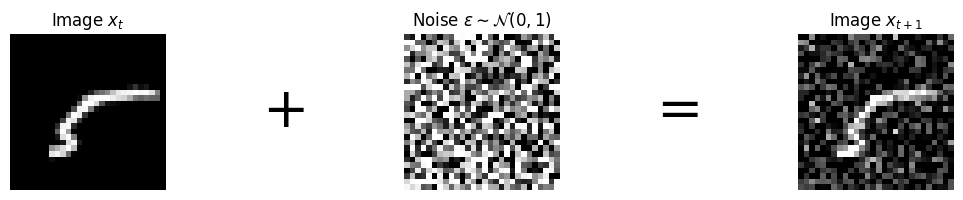

In [6]:
# Illustrate how Image + Noise = Diffused Image

sample_idx = np.random.randint(len(train_dataset))
sample_image, sample_label = train_dataset[sample_idx]  # normalized ~[-1, 1]
eps = torch.randn_like(sample_image)

beta = 0.25
signal_part = torch.sqrt(torch.tensor(1 - beta, dtype=sample_image.dtype, device=sample_image.device)) * sample_image
noise_part  = torch.sqrt(torch.tensor(beta, dtype=sample_image.dtype, device=sample_image.device)) * eps
diffused = signal_part + noise_part

vmin, vmax = -1, 1  # fixed range for normalized images

fig, axes = plt.subplots(1, 5, figsize=(10, 2))

axes[0].imshow(sample_image.squeeze().cpu(), cmap="gray", vmin=vmin, vmax=vmax)
axes[0].set_title("Image $x_t$")
axes[0].axis("off")

axes[1].text(0.5, 0.5, "+", fontsize=40, ha="center", va="center")
axes[1].axis("off")

axes[2].imshow(eps.clamp(vmin, vmax).squeeze().cpu(), cmap="gray", vmin=vmin, vmax=vmax)
axes[2].set_title(r"Noise $\varepsilon \sim \mathcal{N}(0, 1)$")
axes[2].axis("off")

axes[3].text(0.5, 0.5, "=", fontsize=40, ha="center", va="center")
axes[3].axis("off")

axes[4].imshow(diffused.squeeze().cpu(), cmap="gray", vmin=vmin, vmax=vmax)
axes[4].set_title("Image $x_{t+1}$")
axes[4].axis("off")

plt.tight_layout()
plt.show()

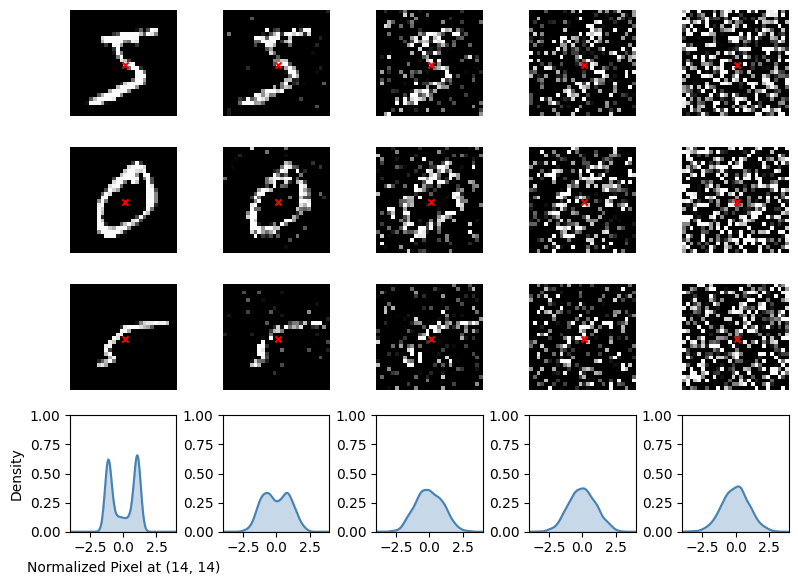

In [7]:
# Diffuse all images in the dataset step by step

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Define different beta values to test (5 levels)
beta_values = np.array([0.0, 0.25, 0.5, 0.75, 1.0])

# Create a figure with 4 rows: numbers diffusion (2 rows), images and pixel distributions
fig, axes = plt.subplots(4, 5, figsize=(8, 6))

# Convert sample_image to numpy array to avoid __array__ deprecation warning
sample_image_np = np.asarray(sample_image)

# Define pixel coordinates to track across the dataset
pixel_coords = (14, 14)

# Collect pixel values at pixel_coords across the entire dataset for each beta
# Assuming train_dataset is available and contains the MNIST images
num_samples = min(len(train_dataset), 1000)  # Limit to 1000 samples for efficiency

# Get two different digit images for the top rows
digit_image_1, _ = train_dataset[0]  # First digit
digit_image_2, _ = train_dataset[1]  # Second digit
digit_image_1_np = np.asarray(digit_image_1)
digit_image_2_np = np.asarray(digit_image_2)

for idx, beta in enumerate(beta_values):
    # First row: first digit diffusion evolution
    noise_1 = np.random.randn(*digit_image_1_np.shape)
    noisy_digit_1 = np.sqrt(1 - beta) * digit_image_1_np + np.sqrt(beta) * noise_1
    noisy_digit_1_display = np.clip(noisy_digit_1, 0, 1)
    axes[0, idx].imshow(noisy_digit_1_display.squeeze(), cmap='gray')
    axes[0, idx].scatter([pixel_coords[1]], [pixel_coords[0]], c='red', s=20, marker='x')
    axes[0, idx].axis('off')
    
    # Second row: second digit diffusion evolution
    noise_2 = np.random.randn(*digit_image_2_np.shape)
    noisy_digit_2 = np.sqrt(1 - beta) * digit_image_2_np + np.sqrt(beta) * noise_2
    noisy_digit_2_display = np.clip(noisy_digit_2, 0, 1)
    axes[1, idx].imshow(noisy_digit_2_display.squeeze(), cmap='gray')
    axes[1, idx].scatter([pixel_coords[1]], [pixel_coords[0]], c='red', s=20, marker='x')
    axes[1, idx].axis('off')
    
    # Third row: single image diffusion (original sample_image)
    noise = np.random.randn(*sample_image_np.shape)
    noisy_image = np.sqrt(1 - beta) * sample_image_np + np.sqrt(beta) * noise
    
    # Clip values to valid range for display
    noisy_image_display = np.clip(noisy_image, 0, 1)
    
    # Display the noisy image
    axes[2, idx].imshow(noisy_image_display.squeeze(), cmap='gray')
    axes[2, idx].scatter([pixel_coords[1]], [pixel_coords[0]], c='red', s=20, marker='x')
    axes[2, idx].axis('off')
    
    # Fourth row: distribution of pixel values at pixel_coords across the dataset
    pixel_values_at_coord = []
    for i in range(num_samples):
        img, _ = train_dataset[i]
        img_np = np.asarray(img)
        noise_i = np.random.randn(*img_np.shape)
        noisy_img = np.sqrt(1 - beta) * img_np + np.sqrt(beta) * noise_i
        pixel_val = noisy_img.squeeze()[pixel_coords[0], pixel_coords[1]]
        pixel_values_at_coord.append(pixel_val)
    
    pixel_values_at_coord = np.array(pixel_values_at_coord)
    
    # Normalize the pixel values to have zero mean and unit variance
    pixel_values_normalized = (pixel_values_at_coord - pixel_values_at_coord.mean()) / (pixel_values_at_coord.std() + 1e-8)
    
    # Plot empirical PDF using kernel density estimation
    x_range = np.linspace(-4, 4, 200)
    kde = gaussian_kde(pixel_values_normalized)
    pdf_values = kde(x_range)
    
    axes[3, idx].plot(x_range, pdf_values, color='steelblue', linewidth=1.5)
    axes[3, idx].fill_between(x_range, pdf_values, alpha=0.3, color='steelblue')
    axes[3, idx].set_xlim(-4, 4)
    axes[3, idx].set_ylim(0, 1.0)
    if idx == 0:
        axes[3, idx].set_ylabel('Density')
        axes[3, idx].set_xlabel(f'Normalized Pixel at {pixel_coords}')

# plt.suptitle('Effect of Different Beta Values on Forward Diffusion', fontsize=14)
plt.tight_layout()
plt.show()


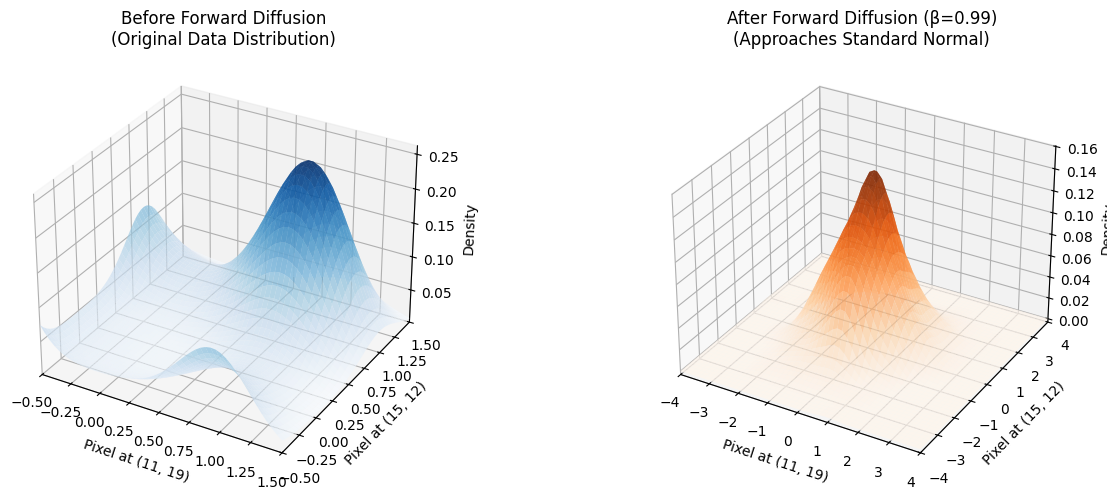

In [8]:
# Compare 2D distribution of two random pixels before and after forward diffusion
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D

# Figure size settings
FIG_WIDTH = 14  # Increased width to prevent label truncation
FIG_HEIGHT = 5

# Select two random pixel coordinates
np.random.seed(42)
pixel1_coords = (np.random.randint(5, 23), np.random.randint(5, 23))
pixel2_coords = (np.random.randint(5, 23), np.random.randint(5, 23))

# Collect pixel values across the dataset
num_samples = 1000
pixel1_values_original = []
pixel2_values_original = []
pixel1_values_corrupted = []
pixel2_values_corrupted = []

beta_final = 0.99  # High beta for near-complete corruption

for i in range(num_samples):
    img, _ = train_dataset[i]
    img_np = np.asarray(img).squeeze()
    
    # Original pixel values
    pixel1_values_original.append(img_np[pixel1_coords[0], pixel1_coords[1]])
    pixel2_values_original.append(img_np[pixel2_coords[0], pixel2_coords[1]])
    
    # Corrupted pixel values (forward diffusion)
    noise = np.random.randn(*img_np.shape)
    noisy_img = np.sqrt(1 - beta_final) * img_np + np.sqrt(beta_final) * noise
    pixel1_values_corrupted.append(noisy_img[pixel1_coords[0], pixel1_coords[1]])
    pixel2_values_corrupted.append(noisy_img[pixel2_coords[0], pixel2_coords[1]])

pixel1_values_original = np.array(pixel1_values_original)
pixel2_values_original = np.array(pixel2_values_original)
pixel1_values_corrupted = np.array(pixel1_values_corrupted)
pixel2_values_corrupted = np.array(pixel2_values_corrupted)

# Create figure with two 3D subplots
fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))

# Left plot: Original distribution (before corruption) - 3D with density
ax1 = fig.add_subplot(1, 2, 1, projection='3d')

# Compute 2D KDE for original data
xy_original = np.vstack([pixel1_values_original, pixel2_values_original])
kde_original = gaussian_kde(xy_original)

# Create grid for density surface
x_grid = np.linspace(-0.5, 1.5, 50)
y_grid = np.linspace(-0.5, 1.5, 50)
X, Y = np.meshgrid(x_grid, y_grid)
positions = np.vstack([X.ravel(), Y.ravel()])
Z_original = kde_original(positions).reshape(X.shape)

# Plot surface
ax1.plot_surface(X, Y, Z_original, cmap='Blues', alpha=0.7, edgecolor='none')
ax1.set_xlabel(f'Pixel at {pixel1_coords}')
ax1.set_ylabel(f'Pixel at {pixel2_coords}')
ax1.set_zlabel('Density')
ax1.set_title('Before Forward Diffusion\n(Original Data Distribution)')
ax1.set_xlim(-0.5, 1.5)
ax1.set_ylim(-0.5, 1.5)

# Right plot: Corrupted distribution (after forward diffusion) - 3D with density
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

# Compute 2D KDE for corrupted data
xy_corrupted = np.vstack([pixel1_values_corrupted, pixel2_values_corrupted])
kde_corrupted = gaussian_kde(xy_corrupted)

# Create grid for density surface
x_grid2 = np.linspace(-4, 4, 50)
y_grid2 = np.linspace(-4, 4, 50)
X2, Y2 = np.meshgrid(x_grid2, y_grid2)
positions2 = np.vstack([X2.ravel(), Y2.ravel()])
Z_corrupted = kde_corrupted(positions2).reshape(X2.shape)

# Plot surface
ax2.plot_surface(X2, Y2, Z_corrupted, cmap='Oranges', alpha=0.7, edgecolor='none')
ax2.set_xlabel(f'Pixel at {pixel1_coords}')
ax2.set_ylabel(f'Pixel at {pixel2_coords}')
ax2.set_zlabel('Density')
ax2.set_title(f'After Forward Diffusion (β={beta_final})\n(Approaches Standard Normal)')
ax2.set_xlim(-4, 4)
ax2.set_ylim(-4, 4)

plt.tight_layout()
plt.show()

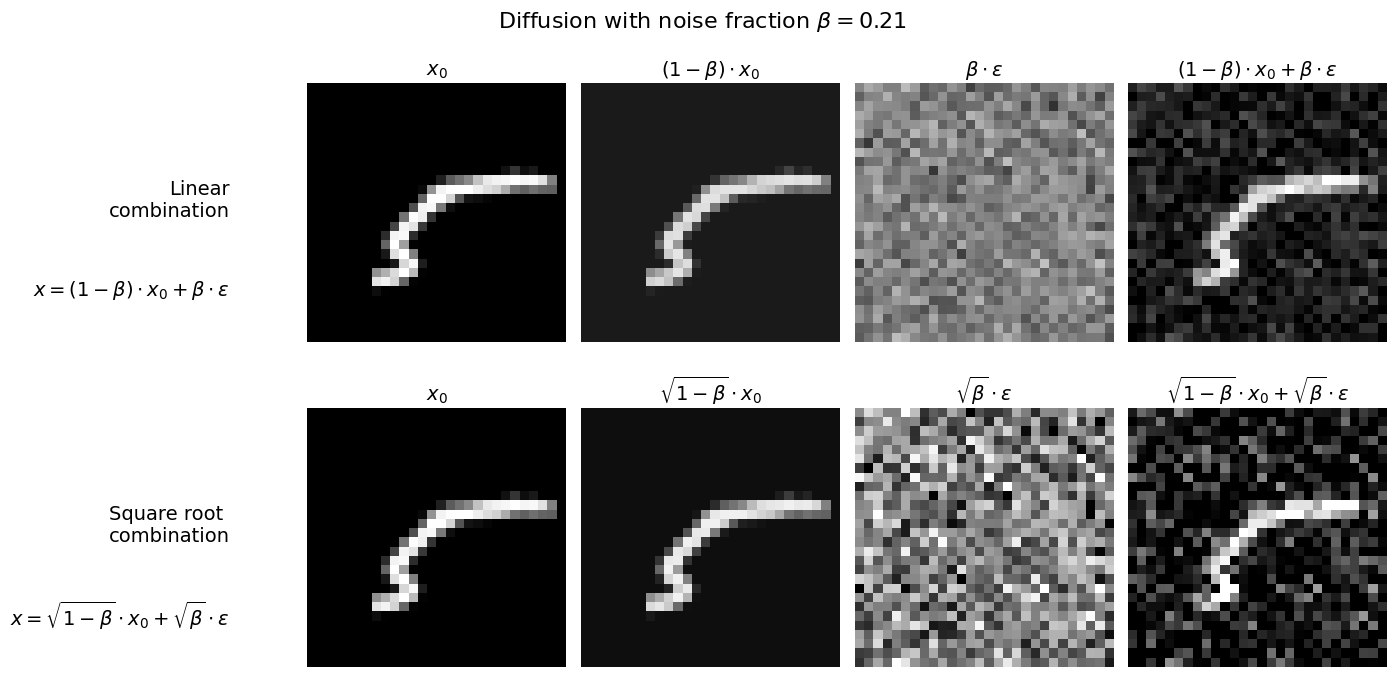

In [9]:
# diffuse the image = shift original pixels by noise value

FONTSIZE = 14

beta = float(np.random.uniform(0.1, 0.5))
fresh_noise = torch.randn_like(sample_image)

lin_signal = (1 - beta) * sample_image
lin_noise = beta * fresh_noise
lin_x = lin_signal + lin_noise

sqrt_signal = np.sqrt(1 - beta) * sample_image
sqrt_noise = np.sqrt(beta) * fresh_noise
sqrt_x = sqrt_signal + sqrt_noise

# All 4 plots in same figure
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
for ax in axes.ravel():
    ax.axis("off")

# Linear combination row
axes[0, 0].imshow(sample_image.squeeze(), cmap="gray", vmin=-1, vmax=1)
axes[0, 0].set_title(r"$x_0$", fontsize=FONTSIZE)
axes[0, 1].imshow(lin_signal.squeeze(), cmap="gray", vmin=-1, vmax=1)
axes[0, 1].set_title(r"$(1-\beta) \cdot x_0$", fontsize=FONTSIZE)
axes[0, 2].imshow(lin_noise.squeeze(), cmap="gray", vmin=-1, vmax=1)
axes[0, 2].set_title(r"$\beta \cdot \varepsilon$", fontsize=FONTSIZE)
axes[0, 3].imshow(lin_x.squeeze(), cmap="gray", vmin=-1, vmax=1)
axes[0, 3].set_title(r"$(1-\beta) \cdot x_0 + \beta \cdot \varepsilon$", fontsize=FONTSIZE)

# Square root combination row
axes[1, 0].imshow(sample_image.squeeze(), cmap="gray", vmin=-1, vmax=1)
axes[1, 0].set_title(r"$x_0$", fontsize=FONTSIZE)
axes[1, 1].imshow(sqrt_signal.squeeze(), cmap="gray", vmin=-1, vmax=1)
axes[1, 1].set_title(r"$\sqrt{1-\beta} \cdot x_0$", fontsize=FONTSIZE)
axes[1, 2].imshow(sqrt_noise.squeeze(), cmap="gray", vmin=-1, vmax=1)
axes[1, 2].set_title(r"$\sqrt{\beta} \cdot \varepsilon$", fontsize=FONTSIZE)
axes[1, 3].imshow(sqrt_x.squeeze(), cmap="gray", vmin=-1, vmax=1)
axes[1, 3].set_title(r"$\sqrt{1-\beta} \cdot x_0 + \sqrt{\beta} \cdot \varepsilon$", fontsize=FONTSIZE)

# Row labels with formulas
axes[0, 0].text(-0.3, 0.55, "Linear\ncombination", transform=axes[0, 0].transAxes, 
                fontsize=FONTSIZE, va='center', ha='right')
axes[0, 0].text(-0.3, 0.2, r"$x = (1-\beta) \cdot x_0 + \beta \cdot \varepsilon$", transform=axes[0, 0].transAxes, 
                fontsize=FONTSIZE, va='center', ha='right')
axes[1, 0].text(-0.3, 0.55, "Square root \ncombination", transform=axes[1, 0].transAxes, 
                fontsize=FONTSIZE, va='center', ha='right')
axes[1, 0].text(-0.3, 0.2, r"$x = \sqrt{1-\beta} \cdot x_0 + \sqrt{\beta} \cdot \varepsilon$", transform=axes[1, 0].transAxes, 
                fontsize=FONTSIZE, va='center', ha='right')

fig.suptitle(rf"Diffusion with noise fraction $\beta={beta:.2f}$", fontsize=16)
plt.tight_layout()
plt.show()

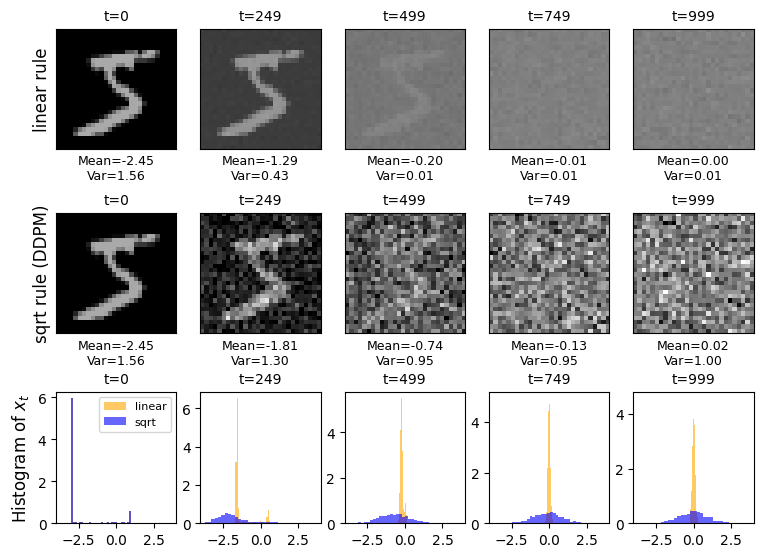

In [14]:
# compare linear and sqrt rule

import numpy as np
import torch
import matplotlib.pyplot as plt

# ----------------------------
# Config
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

T = 1000
beta_start, beta_end = 1e-4, 2e-2
betas = torch.linspace(beta_start, beta_end, T, device=device)  # [T]

num_steps = 5
# pick 5 timesteps including 0 and T-1, evenly spaced
timesteps = np.linspace(0, T-1, num_steps, dtype=int).tolist()

torch.manual_seed(0)
np.random.seed(0)

# ----------------------------
# Pick one image
# ----------------------------
img0, _ = train_dataset[0]              # [1,H,W], torch tensor
x0 = img0.to(device).float()

# Optional: center to [-1,1] so "Gaussian noise" comparison is more meaningful
# Comment out if you prefer raw [0,1].
x0 = x0 * 2.0 - 1.0

# ----------------------------
# Run both forward processes step-by-step
# Use the SAME eps_t at each step for both rules
# ----------------------------
x_sqrt = x0.clone()
x_lin  = x0.clone()

# Pre-generate noises for all steps for reproducibility + fairness
eps_seq = torch.randn((T,) + tuple(x0.shape), device=device)

# Store snapshots
snap_sqrt = {0: x_sqrt.detach().cpu()}
snap_lin  = {0: x_lin.detach().cpu()}

for t in range(1, T):
    beta = betas[t]
    eps  = eps_seq[t]

    # sqrt rule (DDPM)
    a_s = torch.sqrt(1.0 - beta)
    b_s = torch.sqrt(beta)
    x_sqrt = a_s * x_sqrt + b_s * eps

    # linear rule (bad scaling)
    a_l = (1.0 - beta)
    b_l = beta
    x_lin = a_l * x_lin + b_l * eps

    if t in timesteps:
        snap_sqrt[t] = x_sqrt.detach().cpu()
        snap_lin[t]  = x_lin.detach().cpu()

# Ensure all requested timesteps exist (they should)
snap_sqrt = [snap_sqrt[t] for t in timesteps]
snap_lin  = [snap_lin[t] for t in timesteps]

# ----------------------------
# Metrics + display helpers
# ----------------------------
def mean_and_var(x_cpu):
    x = x_cpu.numpy()
    mean = np.mean(x)
    var = np.var(x)
    return mean, var

# Fixed display range so you can SEE variance collapse vs preserved energy
# For [-1,1] centered MNIST, this is a good default.
vmin, vmax = -3.0, 3.0

# ----------------------------
# Plot: 3 rows × 5 cols (images linear, images sqrt, histograms)
# ----------------------------
fig, axes = plt.subplots(3, num_steps, figsize=(1.8*num_steps, 6.5))
plt.subplots_adjust(hspace=0.4)

for j, t in enumerate(timesteps):
    # --- linear row ---
    x_img2 = snap_lin[j].squeeze(0)
    mean2, var2 = mean_and_var(snap_lin[j])

    ax = axes[0, j]
    ax.imshow(x_img2, cmap="gray", vmin=vmin, vmax=vmax)
    ax.set_title(f"t={t}", fontsize=10)
    ax.set_xlabel(f"Mean={mean2:.2f}\nVar={var2:.2f}", fontsize=9)
    ax.set_xticks([]); ax.set_yticks([])

    # --- sqrt row ---
    x_img = snap_sqrt[j].squeeze(0)  # [H,W]
    mean, var = mean_and_var(snap_sqrt[j])

    ax2 = axes[1, j]
    ax2.imshow(x_img, cmap="gray", vmin=vmin, vmax=vmax)
    ax2.set_title(f"t={t}", fontsize=10)
    ax2.set_xlabel(f"Mean={mean:.2f}\nVar={var:.2f}", fontsize=9)
    ax2.set_xticks([]); ax2.set_yticks([])

    # --- histogram row ---
    ax3 = axes[2, j]
    sqrt_vals = snap_sqrt[j].numpy().flatten()
    lin_vals = snap_lin[j].numpy().flatten()
    
    ax3.hist(lin_vals, bins=30, alpha=0.6, label='linear', color='orange', density=True)
    ax3.hist(sqrt_vals, bins=30, alpha=0.6, label='sqrt', color='blue', density=True)
    ax3.set_title(f"t={t}", fontsize=10)
    ax3.set_xlim(-4, 4)
    if j == 0:
        ax3.legend(fontsize=8)

# Row labels
axes[0, 0].set_ylabel("linear rule", fontsize=12)
axes[1, 0].set_ylabel("sqrt rule (DDPM)", fontsize=12)
axes[2, 0].set_ylabel("Histogram of $x_t$", fontsize=12)

plt.show()

Let's prove that square root formula results in standard normal distribution.

##### 1. Prove that $\mathbb{E}[x_t]=0$, $\text{Var}(x_t)=1$ (multivariate case: $\mathbb{E}[x_t]=0$, $\text{Var}(x_t)=\mathbf{I})$ 

 For square root formula
  
  $x_t = \sqrt{1-\beta_t} \cdot x_0 + \sqrt{\beta_t} \cdot \varepsilon, \text{ where } \varepsilon \sim \mathcal{N}(\mathbf{0},\mathbf{I})$
 
 we have:
 
  $\text{Var}(x_t) = \text{Var}(\sqrt{1-\beta_t} \cdot x_0 + \sqrt{\beta_t} \cdot \varepsilon) = $
 
  $\text{Var}(\sqrt{1-\beta_t} \cdot x_0) + \text{Var}(\sqrt{\beta_t} \cdot \varepsilon) =$
 
 $
   (1-\beta_t) \cdot \text{Var}(x_0) + \beta_t \cdot \text{Var}(\varepsilon) = (1-\beta_t) + \beta_t = 1$

##### 2. Prove that $x_t \sim \mathcal{N}(\sqrt{1-\beta_t} \cdot x_{t-1}, \beta_t I)$
for

$x_t = \sqrt{1-\beta_t} \cdot x_{t-1} + \sqrt{\beta_t} \cdot \varepsilon, \text{ where } \varepsilon \sim \mathcal{N}(0,1)$


### Proof:



 ---
   **Property 1 (Scaling)**: 
   - **1D case**: If $X \sim \mathcal{N}(\mu, \sigma^2)$, then $aX \sim \mathcal{N}(a\mu, a^2\sigma^2)$
   - **Multivariate case**: If $X \sim \mathcal{N}(\mu, \Sigma)$, then $aX \sim \mathcal{N}(a\mu, a^2\Sigma)$
   
   In particular, if $\varepsilon \sim \mathcal{N}(0, I)$, then $\sqrt{\beta_t} \cdot \varepsilon \sim \mathcal{N}(0, \beta_t I)$
 
 ---

 
   **Property 2 (Translation)**: 
   - **1D case**: If $Z \sim \mathcal{N}(0, \sigma^2)$, then $Y = \mu + Z \sim \mathcal{N}(\mu, \sigma^2)$
   - **Multivariate case**: If $Z \sim \mathcal{N}(0, \Sigma)$, then $Y = \mu + Z \sim \mathcal{N}(\mu, \Sigma)$
 
  In particular: $x_t = \sqrt{1-\beta_t} \cdot x_{t-1} + \sqrt{\beta_t} \cdot \varepsilon$ where $\varepsilon \sim \mathcal{N}(0, I)$,
  
  then $x_t | x_{t-1} \sim \mathcal{N}(\sqrt{1-\beta_t} \cdot x_{t-1}, \beta_t I)$
 
 ---

## 2. The Markov chain

### **2.1 Markov property for diffusion process**

**Markov property (diffusion)**:
Current noised image $x_t$ depends only on previous step $x_{t-1}$

 ![Markov Forward Process](static/markov_forward.png)

Why? It enables us to sample diffused images efficiently! (helpful for training)

Given that:
- generative process is Gaussian and linear in $x_{t}$
- transitions are Markov

we can generate $x_{t}$ from $x_0$ in ONE step. Let's derive the one-step formula.

**Transition (in terms of $\beta$)**: $x_t = \sqrt{1-\beta_t} \cdot x_{t-1} + \sqrt{\beta_t} \cdot \varepsilon$
  
Let $\alpha_t = 1 - \beta_t$
  
**Transition (in terms of $\alpha$)**: $x_t = \sqrt{\alpha_t} \cdot x_{t-1} + \sqrt{1 - \alpha_t} \cdot \varepsilon$

**Transition (in terms of $\alpha$, unrolled 1 step)**: 
   $x_t = \sqrt{\alpha_t} \cdot (\sqrt{\alpha_{t-1}} \cdot x_{t-2} + \sqrt{1 - \alpha_{t-1}} \cdot \varepsilon_{t-1}) + \sqrt{1 - \alpha_t} \cdot \varepsilon_t$
    
**Transition (in terms of $\alpha$, unrolled T steps)**: 
     $x_t = \sqrt{\alpha_t \cdot \alpha_{t-1} \cdot ... \cdot \alpha_1} \cdot x_0 + \sqrt{1 - \alpha_t \cdot \alpha_{t-1} \cdot ... \cdot \alpha_1} \cdot \varepsilon$
    
  Let 
  $\bar{\alpha}_t = \prod_{i=1}^{t} \alpha_i$
  
**Transition (in terms of $\bar{\alpha}$)**: 
  $x_t = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \varepsilon$

Hence, one can generate $x_{t}$ from $x_0$ in one step (sampling form):

   $$x_t = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, I)$$
   
Which is the same as to sample $x_{t}$ from distribution:
   $$q(x_t | x_0) = \mathcal{N}(\sqrt{\bar{\alpha}_t} \cdot x_0,\space(1 - \bar{\alpha}_t) \cdot I)$$


### **2.1 Markov property for denoising process**

**Markov property (denosing)**:
Previous noised image $x_{t-1}$ depends only on current step $x_{t}$

  ![Markov Backward Process](static/markov_backward.png)

Can we also sample denoised images efficiently? (during inference)

Yes, but not as trivially as for diffusion.

## 3. How to denoise?

**Question 1**: Why cant we just compute the previous step $x_{t-1}$ given known $x_t$?

<img src="static/diffusion_vs_denoising_per_step.png" width="800">

**Answer to both Q1, Q2**: At inference time the noise $\varepsilon$ is **unknown**

<img src="static/diffustion_vs_denoising_aggregated.png" width="800">

**Question 2**: So, how do we generate images $\hat{x}_0$ from noise?

**Answer to Q2**: We train a model to predict the noise itself instead of denoised images!

   <img src="static/ddpm_train.png" width="800">

 Note that the predicted noise also depends on time step $t$:
 $$\varepsilon_\theta=\varepsilon_\theta(x_t,t)

**Question 3**: How to sample from a trained model?

 **Answer to Q3**: We run an iterative denoising procedure

For all $t \in \{0, \ldots, N-1\}$:
1. Estimate cumulative noise $\hat{\varepsilon}_\theta$
2. Estimate original image $\hat{x}_0$
3. Estimate slightly less diffused image $\hat{x}_{t-1}$ (for previous step)

### 3.1 Sampling (inference)

##### 1. Estimate cumulative noise $\hat{\varepsilon}_\theta$

$$\hat{\varepsilon}_\theta = \varepsilon_\theta(x_t, t)$$

##### 2. Estimate original image $\hat{x}_0$

$$\hat{x}_0 = \frac{1}{\sqrt{\bar{\alpha}_t}} \left( x_t - \sqrt{1-\bar{\alpha}_t} \cdot \hat{\varepsilon}_\theta \right)$$

##### 3. Estimate slightly less diffused image $x_{t-1}$

$$x_{t-1} = \sqrt{\bar{\alpha}_{t-1}} \left( x_t + \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \cdot \hat{\varepsilon}_\theta \right) $$

## 4. Let's train a model!

In [6]:
# set device

def get_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    return "cpu"

device = get_device()
print(f"Using device: {device}")

Using device: cuda


### 4.1 CNN + Additive timestep conditioning

  <img src="static/arch_simple_cnn.png" alt="SimpleCNN Architecture" width="400"/>

In [7]:
# SimpleCNNDiffusionModel

class SimpleCNNDiffusionModel(nn.Module):
    def __init__(self, emb_dim=128, time_steps=200):
        super().__init__()
        self.emb_dim = emb_dim
        self.nonlinearity = nn.SiLU()
        self.time_steps = time_steps

        self.time_emb = nn.Embedding(time_steps, emb_dim)
        self.conv_data = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),

            nn.GroupNorm(8, 32),
            self.nonlinearity,
            nn.Conv2d(32, 64, kernel_size=3, padding=1),

            nn.GroupNorm(8, 64),
            self.nonlinearity,
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
        ) 
        self.proj_data = nn.Conv2d(128, emb_dim, kernel_size=1, padding=0)
        self.conv_emb = nn.Conv2d(emb_dim, 1, kernel_size=1, padding=0)

    def forward(self, x, t):
        t_emb = self.time_emb(t).view(-1, self.emb_dim, 1, 1)

        x = x.view(-1, 1, 28, 28) # [batch_size, 1, 28, 28]
        x_emb = self.conv_data(x) # [batch_size, 128, 28, 28]
        x_emb = self.proj_data(x_emb) # [batch_size, emb_dim, 28, 28]

        emb = x_emb + t_emb
        eps = self.conv_emb(emb) # [batch_size, 1, 28, 28]
        return eps

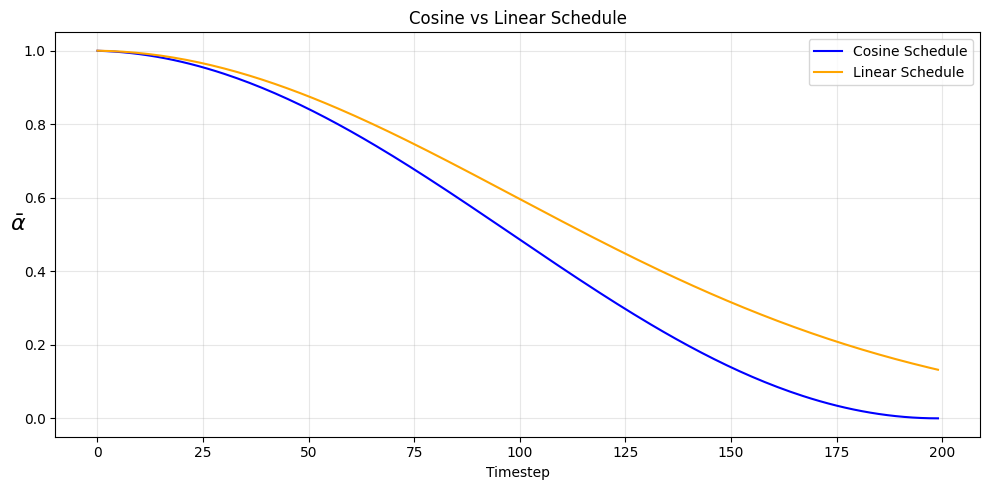

In [8]:
# Beta schedule

viz_time_steps = 200

def cosine_beta_schedule(timesteps, s=0.008, device=None):
    """
    Cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    betas = torch.clamp(betas, 0, 0.999)

    if device is not None:
        betas = betas.to(device)
    return betas

def linear_beta_schedule(timesteps, beta_start=0.0001, beta_end=0.02, device=None):
    """
    Linear schedule as used in the original DDPM paper
    """
    betas = torch.linspace(beta_start, beta_end, timesteps)

    if device is not None:
        betas = betas.to(device)
    return betas

def get_alpha(beta, device=None):
    """
    Compute alpha and alpha_bar from beta schedule.
    
    Args:
        beta: numpy array or tensor of beta values
        device: torch device to place tensors on
    
    Returns:
        alpha: 1 - beta (tensor)
        alpha_bar: cumulative product of alpha (tensor)
    """
    # Convert to tensor if numpy array
    if isinstance(beta, np.ndarray):
        beta = torch.tensor(beta, dtype=torch.float32)
    
    alpha = 1 - beta
    alpha_bar = torch.cumprod(alpha, dim=0)
    
    if device is not None:
        alpha = alpha.to(device)
        alpha_bar = alpha_bar.to(device)
    return alpha, alpha_bar

# Compute both schedules
beta_cosine = cosine_beta_schedule(viz_time_steps)
beta_linear = linear_beta_schedule(viz_time_steps)

# Compute alpha_bar for both schedules using get_alpha
alpha_cosine, alpha_bar_cosine = get_alpha(beta_cosine)
alpha_linear, alpha_bar_linear = get_alpha(beta_linear)

# Visualize and compare alpha_bar for both schedules
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(alpha_bar_cosine.numpy(), label='Cosine Schedule', color='blue')
ax.plot(alpha_bar_linear.numpy(), label='Linear Schedule', color='orange')
ax.set_title(r'Cosine vs Linear Schedule')
ax.set_xlabel('Timestep')
ax.set_ylabel(r'$\bar{\alpha}$', rotation=0, fontsize=16)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

1. Estimate cumulative noise $\hat{\varepsilon}_\theta$

$$\hat{\varepsilon}_\theta = \varepsilon_\theta(x_t, t)$$

 2. Estimate original image $\hat{x}_0$

$$\hat{x}_0 = \frac{1}{\sqrt{\bar{\alpha}_t}} \left( x_t - \sqrt{1-\bar{\alpha}_t} \cdot \hat{\varepsilon}_\theta \right)$$

 3. Estimate slightly less diffused image $x_{t-1}$

$$x_{t-1} = \sqrt{\bar{\alpha}_{t-1}} \left( x_t + \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \cdot \hat{\varepsilon}_\theta \right) $$

In [ ]:
def train_step(model, x_0, optimizer, time_steps, alpha_bar, device):
    """
    Single training step for diffusion model.
    
    Args:
        model: The diffusion model
        x_0: Clean images from dataset [batch_size, 1, 28, 28]
        optimizer: The optimizer
    
    Returns:
        loss value
    """
    optimizer.zero_grad()

    batch_size = x_0.shape[0]
    
    # TODO: Sample a batch of random timesteps
    t = torch.randint(0, time_steps, (batch_size,)).to(device)
    
    # TODO: Sample a batch of noise
    epsilon = torch.randn_like(x_0)
    
    # TODO: Compute diffused image x_t using one-step formula for forward diffusion process
    alpha_bar_t = alpha_bar[t].reshape(-1, 1, 1, 1) # TODO: make alpha_bar[t] broadcastable to [batch_size, 1, 28, 28]
    x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * epsilon
    
    # TODO: Predict noise using model
    epsilon_pred = model(x_t, t)
    
    # TODO: Compute loss (MSE between predicted and actual noise)
    loss = F.mse_loss(epsilon_pred, epsilon)
    
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [10]:
def eval_step(model, x_0, time_steps, alpha_bar, device):
    """Evaluate model on a single batch and return the loss."""

    # TODO: Sample a batch of random timesteps
    t = torch.randint(0, time_steps, (x_0.shape[0],), device=device)
    
    # TODO: Sample a batch of noise
    noise = torch.randn_like(x_0)
    
    # TODO: Compute diffused image x_t using one-step formula for forward diffusion process
    alpha_bar_t = alpha_bar[t].view(-1, 1, 1, 1) # TODO: make broadcastable to [batch_size, 1, 28, 28]
    x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise
    
    # TODO: Predict noise using model
    predicted_noise = model(x_t, t)
    
    # TODO: Compute loss (MSE between predicted and actual noise)
    loss = F.mse_loss(predicted_noise, noise)
    
    return loss.item()

In [11]:
@torch.no_grad()
def sample(
    model,
    n_samples,
    beta,
    alpha,
    alpha_bar,
    device,
    num_steps=None,
    return_intermediates=False,
    intermediate_steps=None,
    x_init=None,
):
    model.eval()

    if num_steps is None:
        num_steps = len(alpha_bar)
    num_steps = int(num_steps)

    beta = beta.to(device=device, dtype=torch.float32) if torch.is_tensor(beta) else torch.tensor(beta, device=device, dtype=torch.float32)
    alpha = alpha.to(device=device, dtype=torch.float32) if torch.is_tensor(alpha) else torch.tensor(alpha, device=device, dtype=torch.float32)
    alpha_bar = alpha_bar.to(device=device, dtype=torch.float32) if torch.is_tensor(alpha_bar) else torch.tensor(alpha_bar, device=device, dtype=torch.float32)

    beta = beta[:num_steps]
    alpha = alpha[:num_steps]
    alpha_bar = alpha_bar[:num_steps]

    # TODO: Initialize x_t (use x_init if provided, otherwise sample from standard normal)
    if x_init is not None:
        x_t = x_init.to(device)
    else:
        x_t = torch.randn(n_samples, 1, 28, 28, device=device)

    if return_intermediates:
        if intermediate_steps is None:
            intermediate_steps = []
        step_set = set(intermediate_steps)
        x0_by_step = {}
        xprev_by_step = {}

    for t in reversed(range(num_steps)):
        t_batch = torch.full((n_samples,), t, dtype=torch.long, device=device)

        # TODO: Predict noise using model
        eps_pred = model(x_t, t_batch)

        alpha_t = alpha[t]
        beta_t = beta[t]
        alpha_bar_t = alpha_bar[t]
        ab = alpha_bar_t.view(-1, 1, 1, 1)
        ab_prev = alpha_bar[t-1].view(-1, 1, 1, 1)

        # TODO: Compute mean of p(x_{t-1} | x_t)
        mean = (x_t - (beta_t / torch.sqrt(1 - ab)) * eps_pred) / torch.sqrt(alpha_t)

        # TODO: Add noise (except for t=0)
        if t > 0:
            noise = torch.randn_like(x_t)
            posterior_std = torch.sqrt(beta_t * (1 - ab_prev) / (1 - ab))
            x_prev = mean + posterior_std * noise
        else:
            x_prev = mean

        if return_intermediates and t in step_set:
            x0_pred = (x_t - torch.sqrt(1 - ab) * eps_pred) / torch.sqrt(ab)
            x0_by_step[t] = x0_pred.detach()
            xprev_by_step[t] = x_prev.detach()

        x_t = x_prev

    model.train()

    if return_intermediates:
        x0_list = [x0_by_step[t] for t in intermediate_steps]
        xprev_list = [xprev_by_step[t] for t in intermediate_steps]
        return x0_list, xprev_list

    return x_prev

In [12]:
# helper viz func 1

def visualize_reconstruction_samples(
    model,
    sample_fn,
    alpha_bar,
    time_steps,
    epoch,
    k=5,
    seed=None,
    dataset=None,
    t_noise=125,
):
    """Visualize k reconstructed samples with unique labels: original, noised at t_noise, and reconstructed."""
    assert k <= 10, "k must be <= 10 since there are only 10 unique digits (0-9)"
    
    if dataset is None:
        dataset = train_dataset

    if t_noise is None:
        t_noise = time_steps - 1

    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    device = next(model.parameters()).device

    # Find indices for unique labels
    label_to_indices = {}
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        label = int(label)
        if label not in label_to_indices:
            label_to_indices[label] = idx
        if len(label_to_indices) >= k:
            break
    
    # If we still need more unique labels, continue searching
    if len(label_to_indices) < k:
        for idx in range(len(dataset)):
            _, label = dataset[idx]
            label = int(label)
            if label not in label_to_indices:
                label_to_indices[label] = idx
            if len(label_to_indices) >= k:
                break
    
    # Sort by label for consistent ordering
    sorted_labels = sorted(label_to_indices.keys())[:k]
    indices = [label_to_indices[label] for label in sorted_labels]

    original_images = []
    x_0_list = []
    labels = []
    for idx in indices:
        img, label = dataset[idx]
        original_images.append(img.squeeze().numpy())
        x_0_list.append(img)
        labels.append(int(label))

    x_0 = torch.stack(x_0_list).to(device)
    ab_t = alpha_bar[t_noise].view(-1, 1, 1, 1)
    eps = torch.randn_like(x_0)
    x_t = torch.sqrt(ab_t) * x_0 + torch.sqrt(1 - ab_t) * eps
    noised_images = x_t.cpu().numpy()

    reconstructed = sample_fn(model, n_samples=k, num_steps=t_noise + 1, x_init=x_t)
    reconstructed = reconstructed.cpu().numpy()

    fig, axes = plt.subplots(3, k, figsize=(2 * k, 6))

    row_labels = ["Original", f"Diffused (t={t_noise})", "Reconstructed"]

    for i in range(k):
        axes[0, i].imshow(original_images[i], cmap="gray")
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])
        axes[0, i].set_title(f"Label {labels[i]}", fontsize=10)

        axes[1, i].imshow(noised_images[i].squeeze(), cmap="gray")
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])

        axes[2, i].imshow(reconstructed[i].squeeze(), cmap="gray")
        axes[2, i].set_xticks([])
        axes[2, i].set_yticks([])

    # Add row labels on the left using set_ylabel on first column
    for row_idx, label in enumerate(row_labels):
        axes[row_idx, 0].set_ylabel(label, fontsize=10, rotation=90)

    plt.suptitle(f"Reconstruction (Epoch {epoch}, t={t_noise})", fontsize=12)
    plt.tight_layout()
    return fig

In [13]:
# helper viz func 2

import math

def visualize_generation_samples(model, sample_fn, time_steps, epoch, k=25, seed=None):
    """Visualize k unconditional generations from pure noise in a sqrt(k) x sqrt(k) grid."""

    if seed is not None:
        torch.manual_seed(seed)

    cols = math.isqrt(k)
    rows = math.ceil(k / cols)
    plot_size = 2
    fig, axes = plt.subplots(rows, cols, figsize=(plot_size * cols, plot_size * rows))
    axes = np.array(axes).reshape(rows, cols)

    generated = sample_fn(model, n_samples=k, num_steps=time_steps)
    generated = generated.cpu().numpy()

    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            if idx < k:
                axes[i, j].imshow(generated[idx].squeeze(), cmap="gray")
            axes[i, j].axis("off")

    plt.suptitle(f"Generated Samples (Epoch {epoch})", fontsize=12)
    plt.tight_layout()
    return fig

In [14]:
# helper viz func 3

from tqdm import tqdm

@torch.no_grad()
def visualize_generation_timeline(model, sample_fn, time_steps, epoch, seed=None, percentages=None):
    """
    Visualize estimated x_0 and denoised x_{t-1} at fixed percentages of timesteps.
    
    Args:
        model: The diffusion model
        sample_fn: Sampling function that returns intermediate states
        time_steps: Total number of timesteps
        epoch: Current epoch number for title label
        seed: Random seed for reproducibility
        percentages: List of percentages of timesteps to visualize (default: every 25% including 100%)
    """
    if percentages is None:
        percentages = [0, 25, 50, 75, 100]
    
    device = next(model.parameters()).device
    
    # Set seed for reproducibility
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    # Compute timesteps from percentages (reversed since we go from T to 0)
    # Clamp to valid range [0, time_steps - 1]
    timestep_indices = [max(0, min(time_steps - 1, int((100 - p) / 100 * (time_steps - 1)))) for p in percentages]
    
    # Use sample_fn to get intermediate states
    # We need to collect x_0 estimates and x_{t-1} at specific timesteps
    x_0_estimates, x_t_minus_1_samples = sample_fn(
        model, 
        n_samples=1, 
        num_steps=time_steps,
        return_intermediates=True,
        intermediate_steps=timestep_indices
    )
    
    n_cols = len(percentages)
    fig, axes = plt.subplots(2, n_cols, figsize=(2 * n_cols, 4))
    
    for col, (pct, t_val) in enumerate(tqdm(zip(percentages, timestep_indices), total=len(percentages), desc="Visualizing")):
        x_0_pred = x_0_estimates[col]
        x_t_minus_1 = x_t_minus_1_samples[col]
        
        # Plot estimated x_0 (top row)
        axes[0, col].imshow(x_0_pred.cpu().squeeze().numpy(), cmap='gray')
        axes[0, col].axis('off')
        axes[0, col].set_title(f't={t_val} ({pct}%)', fontsize=9)
        
        # Plot x_{t-1} (bottom row)
        axes[1, col].imshow(x_t_minus_1.cpu().squeeze().numpy(), cmap='gray')
        axes[1, col].axis('off')
    
    # Add y-axis labels on the left side with more margin
    axes[0, 0].text(-0.3, 0.5, r'$x_0$', transform=axes[0, 0].transAxes, 
                    fontsize=10, verticalalignment='center', rotation=0, fontweight='bold')
    axes[1, 0].text(-0.3, 0.5, r'$x_{t-1}$', transform=axes[1, 0].transAxes, 
                    fontsize=10, verticalalignment='center', rotation=0, fontweight='bold')
    
    plt.suptitle(f'Generation Visualization - Epoch {epoch}', fontsize=12)
    plt.tight_layout()
    plt.subplots_adjust(left=0.08)
    return fig

In [15]:
# Training loop

from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import os
import time
from functools import partial

# Create directory for saving models
os.makedirs("data/experiments/MNIST", exist_ok=True)

# Use cosine schedule for training
beta = cosine_beta_schedule(viz_time_steps).to(device)
alpha, alpha_bar = get_alpha(beta, device)

sample_fn = partial(
    sample, beta=beta, alpha=alpha, alpha_bar=alpha_bar, device=device
)

def train(model, train_dataloader, test_dataloader, num_epochs, learning_rate, time_steps, beta, alpha, alpha_bar, device):
    # Precompute number of model parameters
    num_params = sum(p.numel() for p in model.parameters())
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    model_class_name = model.__class__.__name__
    model_dir = f"data/experiments/MNIST/{model_class_name}"
    gen_samples_dir = f"{model_dir}/viz/gen_samples"
    gen_timeline_dir = f"{model_dir}/viz/gen_timeline"
    recon_samples_dir = f"{model_dir}/viz/recon_samples"
    os.makedirs(gen_samples_dir, exist_ok=True)
    os.makedirs(gen_timeline_dir, exist_ok=True)
    os.makedirs(recon_samples_dir, exist_ok=True)

    sample_fn = partial(
        sample, beta=beta, alpha=alpha, alpha_bar=alpha_bar, device=device
    )

    # Save initial (untrained) model visualizations as epoch -1
    print(f"Model: {model_class_name} | Params: {num_params:,} (trainable: {num_trainable_params:,})")
    print("Samples from initial (untrained) model:")

    fig = visualize_reconstruction_samples(model, sample_fn, alpha_bar, time_steps, epoch=-1, k=5)
    fig.savefig(f"{recon_samples_dir}/-1.png", bbox_inches="tight")
    display(fig)
    plt.close(fig)

    fig = visualize_generation_timeline(model, sample_fn, time_steps, epoch=-1, seed=42)
    fig.savefig(f"{gen_timeline_dir}/-1.png", bbox_inches="tight")
    display(fig)
    plt.close(fig)

    fig = visualize_generation_samples(model, sample_fn, time_steps, epoch=-1)
    fig.savefig(f"{gen_samples_dir}/-1.png", bbox_inches="tight")
    display(fig)
    plt.close(fig)

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        epoch_start_time = time.time()
        total_loss = 0
        num_batches = 0

        model.train()
        for batch_idx, (x_0, _) in enumerate(train_dataloader):
            x_0 = x_0.to(device)

            loss = train_step(model, x_0, optimizer, time_steps, alpha_bar, device)
            total_loss += loss
            num_batches += 1

        avg_train_loss = total_loss / num_batches

        # Evaluate on test set
        model.eval()
        total_test_loss = 0
        num_test_batches = 0
        with torch.no_grad():
            for batch_idx, (x_0, _) in enumerate(test_dataloader):
                x_0 = x_0.to(device)
                test_loss = eval_step(model, x_0, time_steps, alpha_bar, device)
                total_test_loss += test_loss
                num_test_batches += 1

        avg_test_loss = total_test_loss / num_test_batches
        epoch_train_time = time.time() - epoch_start_time

        torch.save(model.state_dict(), f"{model_dir}/model_latest.pth")

        clear_output(wait=True)

        fig = visualize_reconstruction_samples(model, sample_fn, alpha_bar, time_steps, epoch, k=5, seed=42)
        fig.savefig(f"{recon_samples_dir}/{epoch}.png", bbox_inches="tight")
        display(fig)
        plt.close(fig)

        fig = visualize_generation_timeline(model, sample_fn, time_steps, epoch, seed=42)
        fig.savefig(f"{gen_timeline_dir}/{epoch}.png", bbox_inches="tight")
        display(fig)
        plt.close(fig)

        fig = visualize_generation_samples(model, sample_fn, time_steps, epoch, seed=42)
        fig.savefig(f"{gen_samples_dir}/{epoch}.png", bbox_inches="tight")
        display(fig)
        plt.close(fig)

        print(f"Model: {model_class_name} | Params: {num_params:,} (trainable: {num_trainable_params:,})")
        print(f"Epoch {epoch}/{num_epochs-1} completed. Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f} | Train Time: {epoch_train_time:.2f}s")

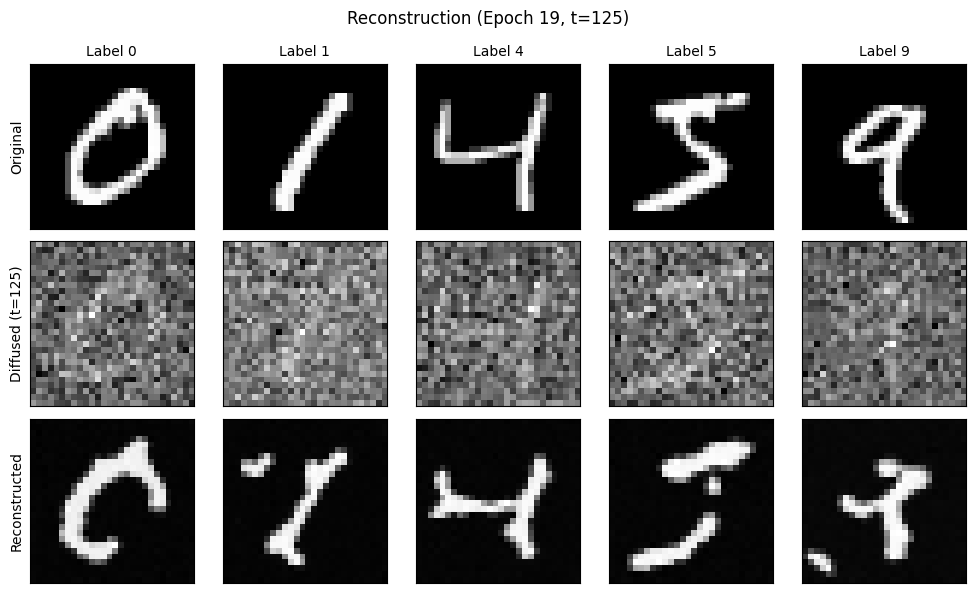

Visualizing: 100%|██████████| 5/5 [00:00<00:00, 511.00it/s]


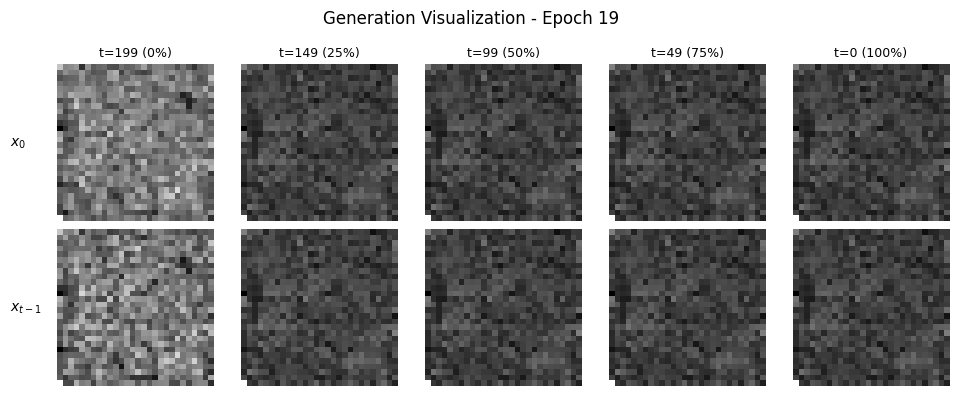

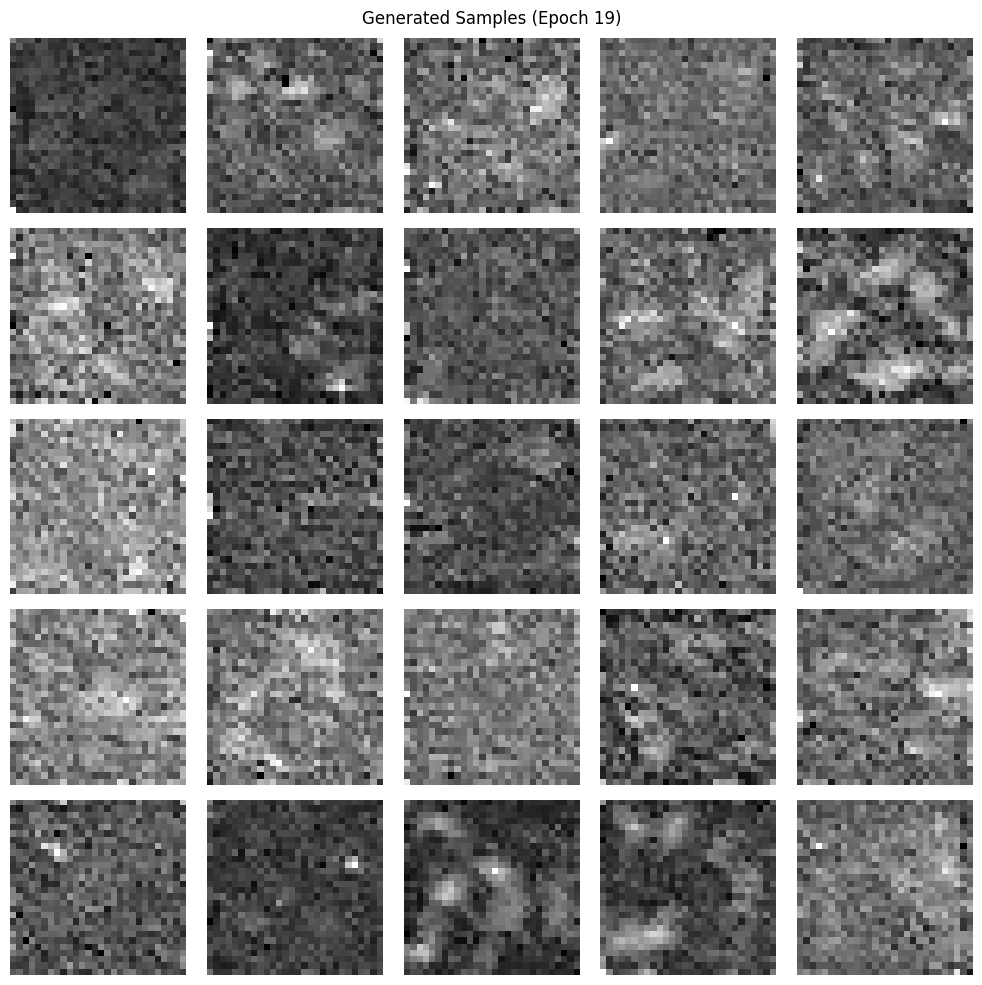

Epochs: 100%|██████████| 20/20 [06:34<00:00, 19.75s/it]

Model: SimpleCNNDiffusionModel | Params: 135,105 (trainable: 135,105)
Epoch 19/19 completed. Train Loss: 0.0587 | Test Loss: 0.0580 | Train Time: 17.11s


In [16]:
# Train SimpleCNNDiffusionModel

# Training hyperparameters
NUM_EPOCHS = 20
BATCH_SIZE = 64
LEARNING_RATE = 2e-4
TIME_STEPS = 200

# Setup optimizer
model = SimpleCNNDiffusionModel().to(device)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

train(
    model,
    train_loader,
    test_loader,
    NUM_EPOCHS,
    LEARNING_RATE,
    TIME_STEPS,
    beta,
    alpha,
    alpha_bar,
    device
)

### 4.1 ResNet + Sinusoidal Time embeddings + FiLM time conditioning

 In diffusion with $T \sim 1000$, we care about distinctions at very different $t$-ranges:
 
 - **coarse**: $t$ differs by hundreds (noise level massively different)
 - **medium**: differs by tens
 - **fine**: differs by 1–2 steps (especially near the end)

 If you want a basis of sinusoids that can represent functions of $t$ at all these resolutions, you want periods ranging roughly from $\sim 1$ up to $\sim T$ (or more).
 
 Geometric spacing gives you periods like:
 
 $$1, 2, 4, 8, 16, \ldots, 1024$$
 
 i.e. evenly spaced on a log scale.

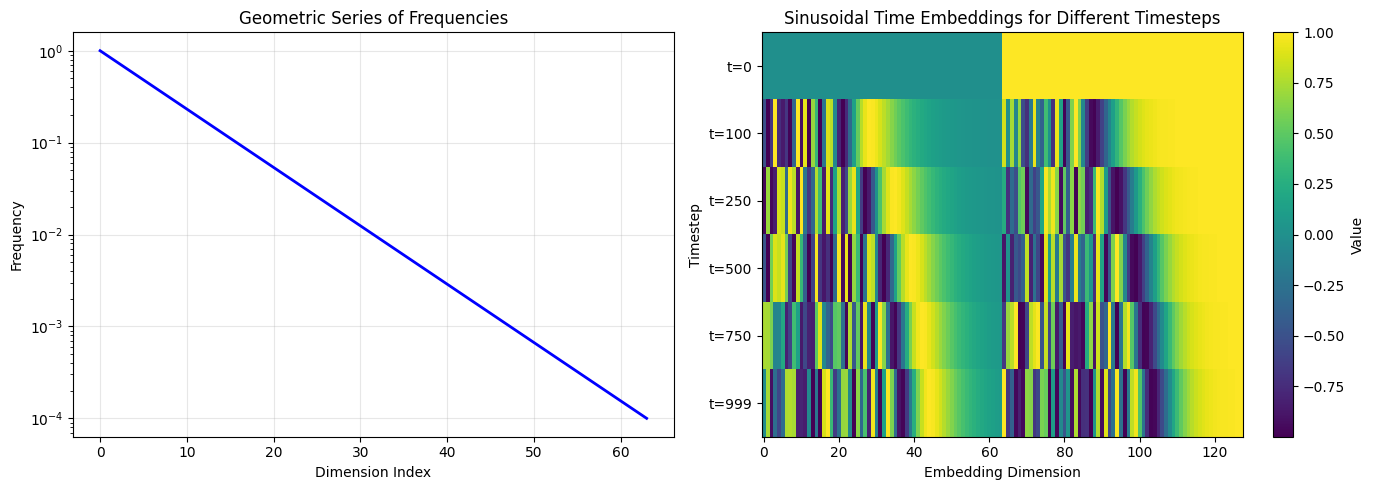

In [17]:
# Visualize geometric series of frequencies used in sinusoidal time embeddings
import math

# Geometric series of frequencies: from 1 to 1/10000
half_dim = 64  # Example embedding dimension / 2
freqs = 10000 ** (-np.arange(half_dim) / (half_dim - 1)) # use half of the frequencies per sin/cos embeding half

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Frequency values across dimensions
axes[0].plot(freqs, 'b-', linewidth=2)
axes[0].set_xlabel('Dimension Index')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Geometric Series of Frequencies')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

# Plot 2: Sinusoidal embeddings for different timesteps (heatmap)
timesteps = np.array([0, 100, 250, 500, 750, 999])
emb_matrix = []
for t in timesteps:
    emb = t * freqs
    sin_emb = np.sin(emb)
    cos_emb = np.cos(emb)
    full_emb = np.concatenate([sin_emb, cos_emb])
    emb_matrix.append(full_emb)

emb_matrix = np.array(emb_matrix)
im = axes[1].imshow(emb_matrix, aspect='auto', cmap='viridis')
axes[1].set_xlabel('Embedding Dimension')
axes[1].set_ylabel('Timestep')
axes[1].set_yticks(range(len(timesteps)))
axes[1].set_yticklabels([f't={t}' for t in timesteps])
axes[1].set_title('Sinusoidal Time Embeddings for Different Timesteps')
plt.colorbar(im, ax=axes[1], label='Value')

plt.tight_layout()
plt.show()

In [18]:
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.emb_dim = emb_dim

    def forward(self, t):
        # TODO 1: Calculate half_dim (we create sin and cos embeddings separately)
        # Hint: Divide emb_dim by 2
        half_dim = self.emb_dim // 2

        # TODO 2: Create geometric freq
        # This creates a geometric series of frequencies for each half of embedding (sin/cos)
        emb_power = torch.arange(half_dim, device=t.device) / (half_dim - 1)
        emb = 10_000.0 ** (-emb_power)
        
        # TODO 3: Multiply timesteps by frequencies (outer product)
        # Hint: t[:, None].float() * emb[None, :]
        # Shape: [batch_size, half_dim]
        emb = t[:, None].float() * emb[None, :]
        
        # TODO 4: Apply sin and cos, then concatenate
        # Hint: torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        # Final shape: [batch_size, emb_dim]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        
        return emb

  <img src="static/arch_residual_block.png" alt="Residual Block Architecture" width="400">

In [19]:
class DDPMResBlock(nn.Module):
    """
    Residual block with time embedding via FiLM conditioning.
    
    Structure: norm -> nonlin -> conv -> time_emb -> norm -> nonlin -> conv -> skip
    With FiLM (Feature-wise Linear Modulation) for time conditioning.
    """
    def __init__(self, in_channels, out_channels, t_emb_dim, nonlinearity=nn.SiLU()):
        super().__init__()
        self.nonlinearity = nonlinearity
        
        # TODO: First conv path:
        self.conv_1 = nn.Sequential(
            nn.GroupNorm(8, in_channels),
            self.nonlinearity,
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, padding_mode="reflect")
        )
        
        # TODO: Time embedding projection (shift and scale)
        self.time_proj = nn.Sequential(
            self.nonlinearity,
            nn.Linear(t_emb_dim, out_channels * 2)
        )

        # TODO: Second conv path:
        self.conv_2 = nn.Sequential(
            nn.GroupNorm(8, out_channels),
            self.nonlinearity,
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, padding_mode="reflect")
        )
        
        # TODO: Skip connection
        self.residual_conn = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        
        # TODO: Initialize last conv to zero for better training stability w/ nn.init.zeros_
        nn.init.zeros_(self.conv_2[2].weight)
        nn.init.zeros_(self.conv_2[2].bias)

    def forward(self, x, t_emb):
        h = x
        
        # TODO: First block: norm -> nonlin -> conv
        h = self.conv_1(h)
        
        # TODO: Add time embedding (shift and scale)
        t_shift_scale = self.time_proj(t_emb)
        t_shift, t_scale = t_shift_scale.chunk(2, dim=1)
        t_shift = t_shift.unsqueeze(-1).unsqueeze(-1)
        t_scale = t_scale.unsqueeze(-1).unsqueeze(-1)
        h = h * (1 + t_scale) + t_shift
        
        # TODO: Second block: norm -> nonlin -> conv
        h = self.conv_2(h)
        
        # TODO: Return residual connection
        return h + self.residual_conn(x)

 <img src="static/arch_residual_net.png" width="400px">

In [20]:
class ResnetDiffusionModel(nn.Module):
    def __init__(self, emb_dim=128, time_steps=1000):
        super().__init__()
        self.emb_dim = emb_dim
        self.time_steps = time_steps
        self.nonlinearity = nn.SiLU()

        self.time_emb = SinusoidalTimeEmbedding(emb_dim)
        self.time_mlp = nn.Sequential(
            nn.Linear(emb_dim, emb_dim*4),
            self.nonlinearity,
            nn.Linear(emb_dim*4, emb_dim),
        )
        
        # Initial convolution
        self.conv_in = nn.Conv2d(1, 64, kernel_size=3, padding=1, padding_mode="reflect")
        
        # Stack of ResBlocks at fixed resolution (no downsampling/upsampling)
        self.res1 = DDPMResBlock(64, 128, emb_dim, self.nonlinearity)
        self.res2 = DDPMResBlock(128, 128, emb_dim, self.nonlinearity)
        self.res3 = DDPMResBlock(128, 128, emb_dim, self.nonlinearity)
        self.res4 = DDPMResBlock(128, 64, emb_dim, self.nonlinearity)
        
        # Output convolution
        self.norm_out = nn.GroupNorm(8, 64)
        self.conv_out = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x, t):
        t_emb = self.time_emb(t)
        t_emb = self.time_mlp(t_emb)

        x = x.view(-1, 1, 28, 28)  # [batch_size, 1, 28, 28]
        
        # Initial conv
        h = self.conv_in(x)  # [batch_size, 64, 28, 28]
        
        # Sequential ResBlocks (no skip connections, fixed resolution)
        h = self.res1(h, t_emb)  # [batch_size, 128, 28, 28]
        h = self.res2(h, t_emb)  # [batch_size, 128, 28, 28]
        h = self.res3(h, t_emb)  # [batch_size, 128, 28, 28]
        h = self.res4(h, t_emb)  # [batch_size, 64, 28, 28]
        
        # Output
        h = self.norm_out(h)
        h = self.nonlinearity(h)
        eps = self.conv_out(h)  # [batch_size, 1, 28, 28]
        
        return eps

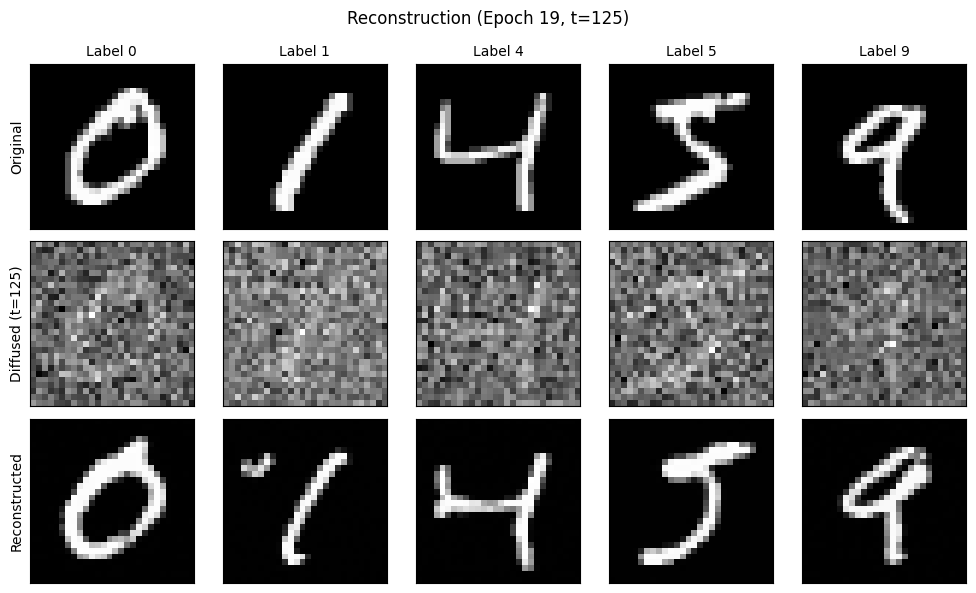

Visualizing: 100%|██████████| 5/5 [00:00<00:00, 413.25it/s]


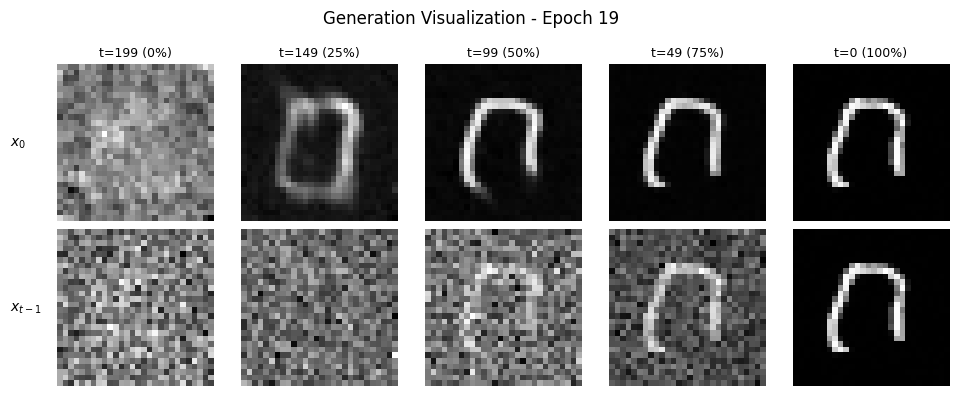

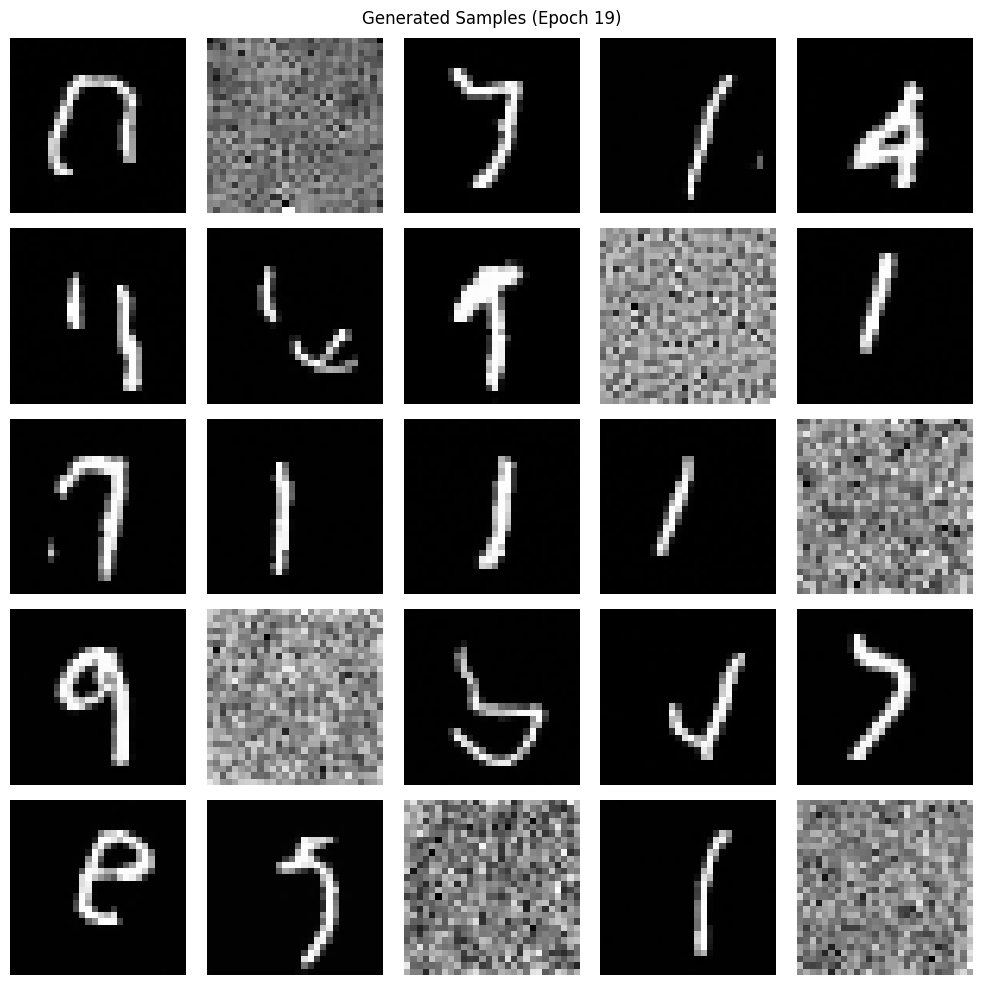

Epochs: 100%|██████████| 20/20 [28:55<00:00, 86.79s/it]

Model: ResnetDiffusionModel | Params: 1,222,529 (trainable: 1,222,529)
Epoch 19/19 completed. Train Loss: 0.0366 | Test Loss: 0.0420 | Train Time: 81.65s


In [21]:
# Train ResnetDiffusionModel

# Training hyperparameters
NUM_EPOCHS = 20
BATCH_SIZE = 64
LEARNING_RATE = 2e-4
TIME_STEPS = 200

# Setup optimizer
model = ResnetDiffusionModel().to(device)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

train(
    model,
    train_loader,
    test_loader,
    NUM_EPOCHS,
    LEARNING_RATE,
    TIME_STEPS,
    beta,
    alpha,
    alpha_bar,
    device
)

### 4.3 U-Net + Attention

<img src="static/arch_residual_attn_block.png" width="350">

In [22]:
class DDPMResAttnBlock(nn.Module):
    """
    Residual + Attention block with time embedding via FiLM conditioning.

      ResNet: GN -> SiLU -> Conv -> +time -> GN -> SiLU -> Conv -> +skip
      Attn:   reshape -> GN -> MHA -> reshape -> +skip
    """
    def __init__(self, in_channels, out_channels, t_emb_dim, num_heads=4, use_attn=True):
        super().__init__()
        self.use_attn = use_attn
        self.nonlinearity = nn.SiLU()

        # TODO: First conv path (GN -> SiLU -> Conv in->out)
        self.conv_1 = nn.Sequential(
            nn.GroupNorm(8, in_channels),
            self.nonlinearity,
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, padding_mode="reflect"),
        )

        # TODO: Time embedding projection (SiLU -> Linear t_emb_dim->out_channels)
        self.time_proj = nn.Sequential(
            self.nonlinearity,
            nn.Linear(t_emb_dim, out_channels * 2)
        )

        # TODO: Second conv path (GN -> SiLU -> Conv out->out)
        self.conv_2 = nn.Sequential(
            nn.GroupNorm(8, out_channels),
            self.nonlinearity,
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, padding_mode="reflect"),
        )

        # TODO: Residual skip (1x1 Conv in->out OR Identity if you want)
        self.skip_conn = nn.Conv2d(in_channels, out_channels, kernel_size=1)

        # TODO: Attention modules (GroupNorm + MultiheadAttention with embed_dim=out_channels)
        if self.use_attn:
            self.attn_norm = nn.GroupNorm(8, out_channels)
            self.mha = nn.MultiheadAttention(out_channels, num_heads, batch_first=True)

    def forward(self, x, t_emb):
        h = x

        # TODO: ResNet part: conv_1
        h = self.conv_1(h)

        # TODO: Use FiLM
        t_emb = self.time_proj(t_emb)
        scale, shift = t_emb.chunk(2, dim=1)
        scale = scale.unsqueeze(-1).unsqueeze(-1)
        shift = shift.unsqueeze(-1).unsqueeze(-1)
        h = (1 + scale) * h + shift

        # TODO: ResNet part: conv_2
        h = self.conv_2(h)

        # TODO: Residual add
        h = h + self.skip_conn(x)

        if self.use_attn:
            # TODO: Attention part
            B, C, H, W = h.shape
            a = h.view(B, C, -1)  # (B, C, H*W)
            a = self.attn_norm(a).permute(0, 2, 1)  # (B, C, H*W) -> (B, H*W, C)
            a, _ = self.mha(a, a, a)
            a = a.view(B, H, W, C).permute(0, 3, 1, 2)  # (B, H*W, C) -> (B, H, W, C) -> (B, C, H, W)
            h = h + a

        return h

<img src="static/arch_unet.png" width="500">

In [23]:
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, stride=2, padding=1, padding_mode="reflect"
        )

    def forward(self, x):
        return self.conv(x)


class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        return self.conv(self.up(x))

In [24]:
class UnetDiffusionModel(nn.Module):
    def __init__(
        self,
        emb_dim=128,
        time_steps=1000,
        dropout=0.1,
        num_heads=4,
        use_attention=False
    ):
        super().__init__()
        self.emb_dim = emb_dim
        self.time_steps = time_steps
        self.nonlinearity = nn.SiLU()

        # TODO: Time embedding
        self.time_emb = SinusoidalTimeEmbedding(emb_dim)
        self.time_mlp = nn.Sequential(
            nn.Linear(emb_dim, emb_dim * 4),
            self.nonlinearity,
            nn.Linear(emb_dim * 4, emb_dim),
        )

        # TODO: Initial convolution
        self.conv_in = nn.Conv2d(1, 32, kernel_size=3, padding=1, padding_mode="reflect")

        # TODO: Encoder blocks
        self.enc1 = DDPMResAttnBlock(32, 32, emb_dim, num_heads=num_heads, use_attn=use_attention)
        self.down1 = Downsample(32, 32)   # 28->14

        self.enc2 = DDPMResAttnBlock(32, 64, emb_dim, num_heads=num_heads, use_attn=use_attention)
        self.down2 = Downsample(64, 64)   # 14->7

        # TODO: Middle block
        self.mid = DDPMResAttnBlock(64, 128, emb_dim, num_heads=num_heads, use_attn=use_attention)

        # TODO: Decoder blocks
        self.dec3 = DDPMResAttnBlock(64 + 64, 64, emb_dim, num_heads=num_heads, use_attn=use_attention)
        self.up3 = Upsample(128, 64)      # 7->14, 128->64

        self.dec2 = DDPMResAttnBlock(32 + 32, 32, emb_dim, num_heads=num_heads, use_attn=use_attention)
        self.up2 = Upsample(64, 32)       # 14->28, 64->32

        # TODO: Output layers
        self.norm_out = nn.GroupNorm(8, 32)
        self.conv_out = nn.Conv2d(32, 1, kernel_size=3, padding=1)

    def forward(self, x, t):
        # TODO: Compute time embedding
        t_emb = self.time_mlp(self.time_emb(t))
        x = x.view(-1, 1, 28, 28)

        # TODO: Initial convolution
        h = self.conv_in(x)

        # TODO: Encoder path
        e1 = self.enc1(h, t_emb)
        h = self.down1(e1)

        e2 = self.enc2(h, t_emb)
        h = self.down2(e2)

        # TODO: Middle block
        h = self.mid(h, t_emb)

        # TODO: Decoder path with skip connections
        h = self.up3(h)
        h = torch.cat([h, e2], dim=1)
        h = self.dec3(h, t_emb)

        h = self.up2(h)
        h = torch.cat([h, e1], dim=1)
        h = self.dec2(h, t_emb)

        # TODO: Output
        h = self.norm_out(h)
        h = self.nonlinearity(h)
        eps = self.conv_out(h)  # [batch_size, 1, 28, 28]

        return eps

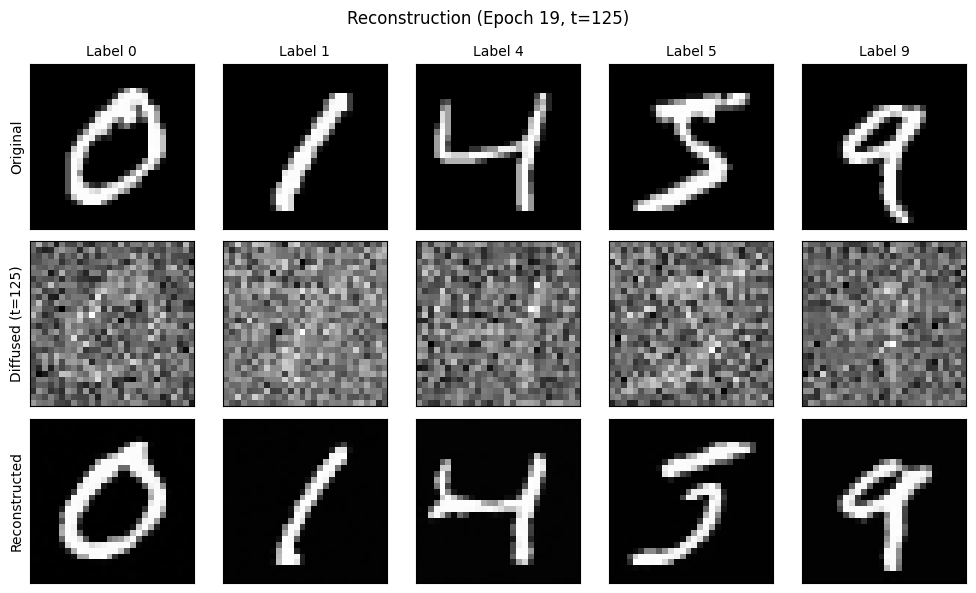

Visualizing: 100%|██████████| 5/5 [00:00<00:00, 447.53it/s]


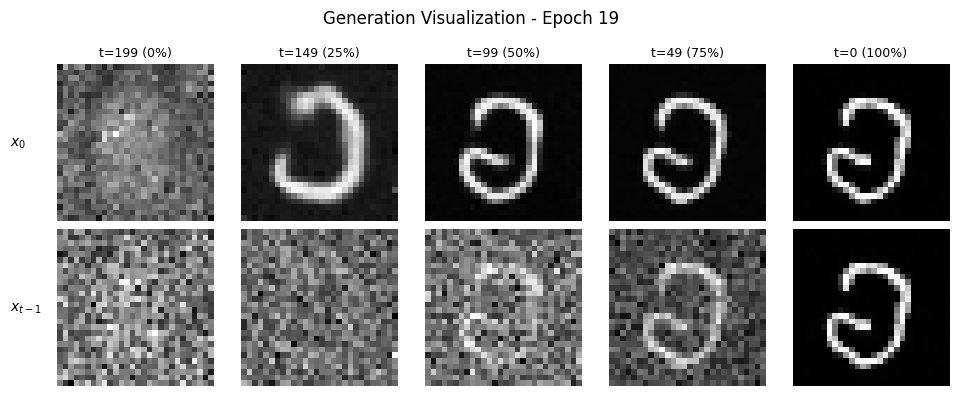

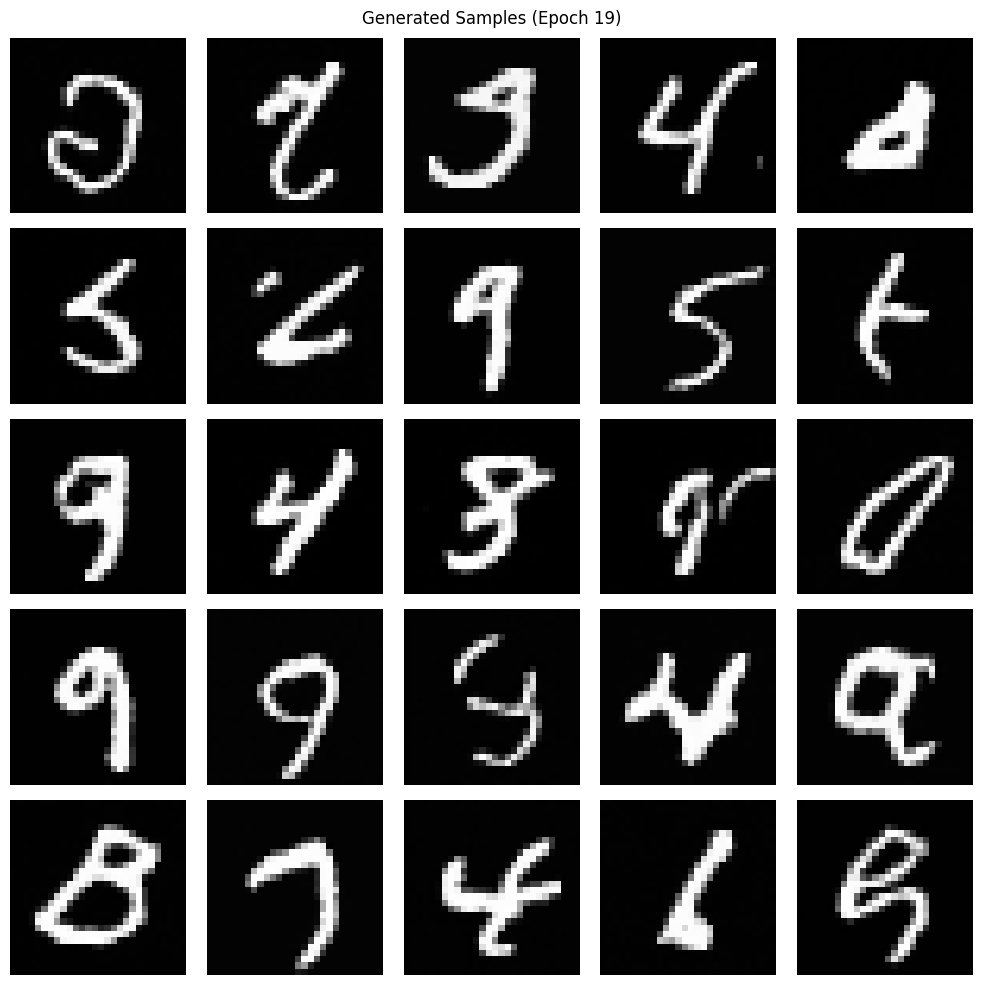

Epochs: 100%|██████████| 20/20 [12:36<00:00, 37.84s/it]

Model: UnetDiffusionModel | Params: 810,273 (trainable: 810,273)
Epoch 19/19 completed. Train Loss: 0.0359 | Test Loss: 0.0431 | Train Time: 34.01s


In [25]:
# Train Unet

# Training hyperparameters
NUM_EPOCHS = 20
BATCH_SIZE = 64
LEARNING_RATE = 2e-4
TIME_STEPS = 200

# Setup optimizer
model = UnetDiffusionModel().to(device)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

train(
    model,
    train_loader,
    test_loader,
    NUM_EPOCHS,
    LEARNING_RATE,
    TIME_STEPS,
    beta,
    alpha,
    alpha_bar,
    device
)

In [ ]:
# Generate GIFs to view the training progress

from pathlib import Path
from PIL import Image

root = Path("data/experiments/MNIST")
assert root.exists(), f"Missing: {root.resolve()}"

viz_subdirs = ["viz/gen_samples", "viz/gen_timeline", "viz/recon_samples"]

def epoch_key(p: Path) -> int:
    try:
        return int(p.stem)
    except ValueError:
        return 10**18

def make_gif(frames: list[Path], out_path: Path, fps: int = 6, loop: int = 0) -> Path:
    imgs = [Image.open(p).convert("RGBA") for p in frames]
    try:
        out_path.parent.mkdir(parents=True, exist_ok=True)
        imgs[0].save(
            out_path,
            save_all=True,
            append_images=imgs[1:],
            duration=int(1000 / fps),
            loop=loop,
            optimize=False,
        )
        return out_path.resolve()
    finally:
        for im in imgs:
            im.close()

for model_dir in sorted(p for p in root.iterdir() if p.is_dir()):
    print(f"\n=== {model_dir.name} ===")
    for rel in viz_subdirs:
        d = model_dir / rel
        out_gif = d / f"{d.name}.gif"
        frames = sorted(d.glob("*.png"), key=epoch_key) if d.exists() else []
        if len(frames) >= 2:
            out = make_gif(frames, out_gif, fps=6)
            print(out)
        else:
            print(out_gif.resolve())


=== ResnetDiffusionModel ===
/Users/a1111/deep-learning-course-2026/data/experiments/MNIST/ResnetDiffusionModel/viz/gen_samples/gen_samples.gif
/Users/a1111/deep-learning-course-2026/data/experiments/MNIST/ResnetDiffusionModel/viz/gen_timeline/gen_timeline.gif
/Users/a1111/deep-learning-course-2026/data/experiments/MNIST/ResnetDiffusionModel/viz/recon_samples/recon_samples.gif

=== SimpleCNNDiffusionModel ===
/Users/a1111/deep-learning-course-2026/data/experiments/MNIST/SimpleCNNDiffusionModel/viz/gen_samples/gen_samples.gif
/Users/a1111/deep-learning-course-2026/data/experiments/MNIST/SimpleCNNDiffusionModel/viz/gen_timeline/gen_timeline.gif
/Users/a1111/deep-learning-course-2026/data/experiments/MNIST/SimpleCNNDiffusionModel/viz/recon_samples/recon_samples.gif

=== UnetDiffusionModel ===
/Users/a1111/deep-learning-course-2026/data/experiments/MNIST/UnetDiffusionModel/viz/gen_samples/gen_samples.gif
/Users/a1111/deep-learning-course-2026/data/experiments/MNIST/UnetDiffusionModel/viz/

## Auxilary visualizations

/tmp/ipython-input-4259352364.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  noisy_image = np.sqrt(1 - beta) * sample_image + np.sqrt(beta) * noise


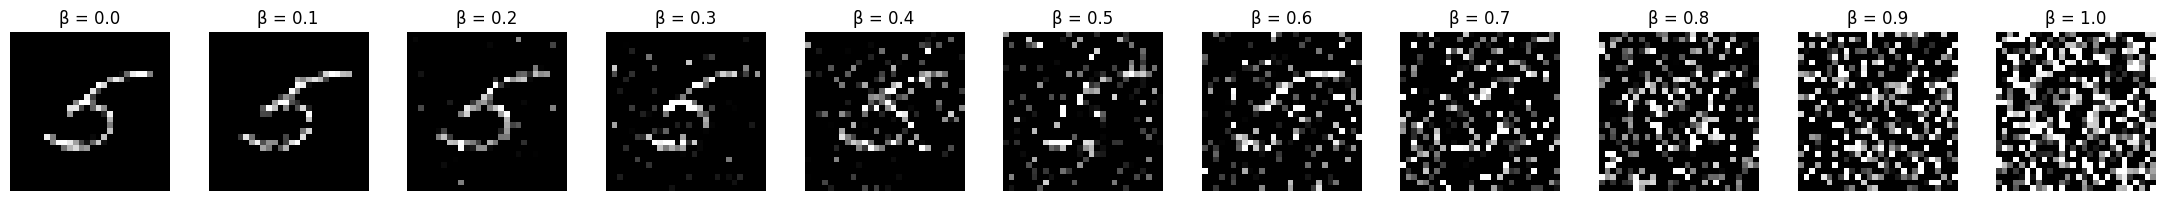

In [27]:
# Visualize the effect of different beta values on a sample image
import matplotlib.pyplot as plt
import numpy as np

# Define different beta values to test
beta_values = np.arange(0.0, 1.1, 0.1)

# Create a figure to show the effect of different betas
fig, axes = plt.subplots(1, 11, figsize=(22, 2))

for idx, beta in enumerate(beta_values):
    # Apply forward diffusion with the given beta
    noise = np.random.randn(*sample_image.shape)
    noisy_image = np.sqrt(1 - beta) * sample_image + np.sqrt(beta) * noise
    
    # Clip values to valid range
    noisy_image = np.clip(noisy_image, 0, 1)
    
    # Display the noisy image
    axes[idx].imshow(noisy_image.squeeze(), cmap='gray')
    axes[idx].set_title(f'β = {beta:.1f}')
    axes[idx].axis('off')

# plt.suptitle('Effect of Different Beta Values on Forward Diffusion', fontsize=14)
plt.tight_layout()
plt.show()


/tmp/ipython-input-2701695812.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x_t = np.sqrt(1 - beta_t) * sample_image + np.sqrt(beta_t) * noise_t
/tmp/ipython-input-2701695812.py:63: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x_t_minus_1 = np.sqrt(1 - beta_t_minus_1) * source_image + np.sqrt(beta_t_minus_1) * epsilon


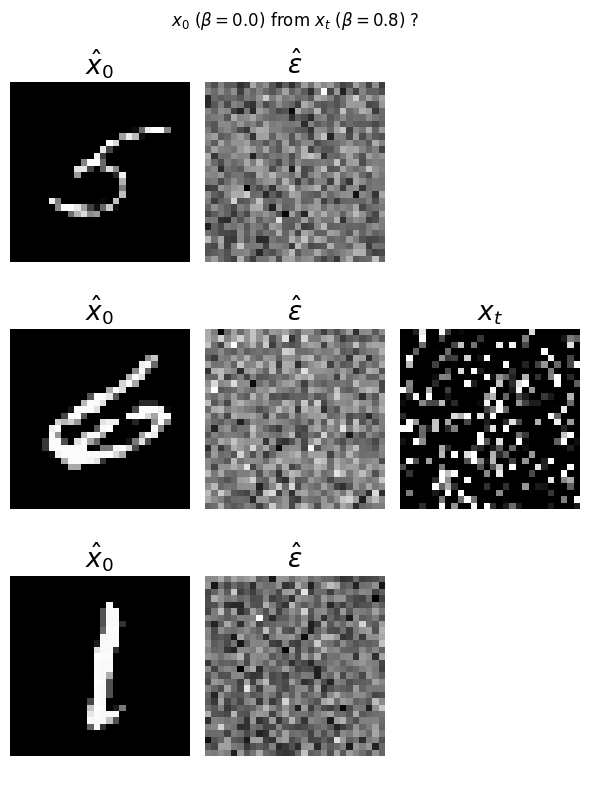

In [28]:
# Generate k=5 random noises and reverse diffusion step
import numpy as np

k = 3
beta_t = 0.8  # Current noise level
UNIQUE_SOURCES_TRUE = True  # When True, show random unique images as candidates (with true sample among them)
RESTORE_INITIAL_TRUE = True  # When True, restore initial image (beta_t_minus_1 = 0)

beta_t_minus_1 = 0.0 if RESTORE_INITIAL_TRUE else 0.4  # Previous noise level

# Fix seed for reproducibility when sampling unique sources
rng = np.random.RandomState(42)

# Create the current noisy image at beta_t
noise_t = rng.randn(*sample_image.shape)
x_t = np.sqrt(1 - beta_t) * sample_image + np.sqrt(beta_t) * noise_t
x_t = np.clip(x_t, 0, 1)

# Generate k random noises and compute possible previous states
# Columns: img_diffused_t-1, noise_t-1, img_diffused_t
fig, axes = plt.subplots(k, 3, figsize=(6, 8))

# Randomly select which row gets the "true" answer (the actual sample_image diffused)
true_row = rng.randint(0, k) if UNIQUE_SOURCES_TRUE else -1

# Get random unique images from the dataset with different labels if UNIQUE_SOURCES_TRUE
if UNIQUE_SOURCES_TRUE:
    # Collect images with different labels
    used_labels = set()
    random_images = []
    random_labels = []
    
    # Shuffle indices to get random order (using fixed seed)
    all_indices = rng.permutation(len(train_dataset))
    
    for idx in all_indices:
        img, label = train_dataset[idx]
        if label not in used_labels:
            used_labels.add(label)
            random_images.append(img.numpy().squeeze())
            random_labels.append(label)
        if len(random_images) >= k - 1:
            break

for i in range(k):
    # Generate random noise for this sample
    epsilon = rng.randn(*sample_image.shape)
    
    # Determine which source image to use
    if UNIQUE_SOURCES_TRUE:
        if i == true_row:
            # Use the actual sample_image for the true row
            source_image = sample_image
        else:
            # Use a random unique image with different label
            # Adjust index to account for the true_row position
            random_idx = i if i < true_row else i - 1
            source_image = random_images[random_idx]
    else:
        source_image = sample_image
    
    # Compute x_{t-1} from the source image with beta_t_minus_1
    x_t_minus_1 = np.sqrt(1 - beta_t_minus_1) * source_image + np.sqrt(beta_t_minus_1) * epsilon
    x_t_minus_1 = np.clip(x_t_minus_1, 0, 1)
    
    # Column 0: x_{t-1} samples (or x_0 if restoring initial)
    axes[i, 0].imshow(x_t_minus_1.squeeze(), cmap='gray')
    x_label = '$\\hat{x}_0$' if RESTORE_INITIAL_TRUE else '$\\hat{x}_{t-1}$'
    axes[i, 0].set_title(x_label, fontsize=19)
    axes[i, 0].axis('off')
    
    # Column 1: noise used for this sample
    axes[i, 1].imshow(epsilon.squeeze(), cmap='gray')
    epsilon_label = '$\\hat{\\epsilon}$' if RESTORE_INITIAL_TRUE else '$\\hat{\\epsilon}_{t}$'
    axes[i, 1].set_title(epsilon_label, fontsize=19)
    axes[i, 1].axis('off')
    
    # Column 2: show x_t only in the middle row
    middle_row = k // 2
    if i == middle_row:
        axes[i, 2].imshow(x_t.squeeze(), cmap='gray')
        axes[i, 2].set_title(f'$x_t$', fontsize=19)
        axes[i, 2].axis('off')
    else:
        axes[i, 2].axis('off')

x_prev_label = '$x_0$' if RESTORE_INITIAL_TRUE else '$x_{t-1}$'
plt.suptitle(f'{x_prev_label} ($\\beta={beta_t_minus_1}$) from $x_t$ ($\\beta={beta_t}$) ?', fontsize=12)
plt.tight_layout()
plt.show()